# Hummer-Szabo Coarse-graining for Model Systems

We demonstrate the numerical challenges of estimating a coarse-grained rate matrix from inter-community passage times for systems with rare event dynamics. We first demonstrate the failure of Hummer-Szabo for the Weiss chain, as well as the extension of the GT algorithm to DTMCs. Then we analyze several different versions of the Hummer-Szabo coarse-graining procedure using a model 16-state network.

In [1]:
#library code
import graph_tran
from graph_tran import ktn_io as kio
from graph_tran import gt_tools as gt
from graph_tran import fpt_stats as fpt
from graph_tran import conversion as convert
from graph_tran.dimred.ktn_analysis import *
#other modules
import numpy as np
import scipy as sp
import scipy.linalg as spla 
from scipy.sparse.linalg import eigs
from scipy.sparse import csr_matrix
from scipy.linalg import eig
from scipy.linalg import expm
from scipy.interpolate import CubicSpline
from pathlib import Path
import pandas as pd
import os
import subprocess
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

Using tqdm package for pretty progress bars!


# Weiss Chain

Consider an 11-state unbranched chain with nearest neighbor connections. Weiss (1967) *Adv. Chem. Phys.* demonstrated that the inter-microstate mean first passage times (MFPTs) are exactly solvable via a recursion relation. We implement this recursion relation below, and compare the exact result to numerical methods for computing MFPTs, including graph transformation and linear algebra approaches.

In [2]:
""" Define variables needed to calculate rates as a function of temperature"""
path = Path('KTN_data/chain')
mindata = np.loadtxt(path/'min.data')
tsdata = np.loadtxt(path/'ts.data')

nmin = mindata.shape[0]
emin = mindata[:,0]
fvibmin = mindata[:, 1]
hordermin = mindata[:, 2]

ets = np.zeros((nmin, nmin))
fvibts = np.zeros((nmin, nmin))
horderts = np.ones((nmin, nmin))
exist = np.zeros((nmin, nmin))

for i in range(tsdata.shape[0]):
    j1 = int(tsdata[i, 3]) - 1
    j2 = int(tsdata[i, 4]) - 1
    exist[j1, j2] = 1
    exist[j2, j1] = 1
    ets[j1, j2] = tsdata[i, 0]
    ets[j2, j1] = tsdata[i, 0]
    fvibts[j1, j2] = tsdata[i, 1]
    fvibts[j2, j1] = tsdata[i, 1]
    horderts[j1, j2] = tsdata[i, 2]
    horderts[j2, j1] = tsdata[i, 2]


In [3]:
def Kmat(temp):
    """Return a rate matrix, (nmin x nmin) for specified temperature."""
    K = np.zeros((nmin, nmin), dtype=np.longdouble)
    for j in range(nmin):
        vib = np.exp((fvibmin - fvibts[:,j])/2).astype(np.longdouble)
        order = hordermin/(2*np.pi*horderts[:,j])
        nrg = np.exp(-(ets[:,j] - emin)/temp).astype(np.longdouble)
        K[:, j] = exist[:, j]*vib*order*nrg

    K = K.T
    for i in range(nmin):
        K[i, i] = -np.sum(K[:,i])
    #return transpose since ts.data assumes i->j and we want i<-j
    return K

def peq(temp):
    """Return equilibrium probabilities for specified temperature."""
    zvec = np.exp(-fvibmin/2)*np.exp(-emin/temp)/hordermin
    zvec = zvec.astype(np.longdouble)
    return zvec/np.sum(zvec)

#Compute matrix of MFPTs with the analytical Weiss formulae
def weiss(temp):
    """Return the matrix of mean first passage times using the recursive
    formulae in Weiss (1967) Adv. Chem. Phys. 13, 1-18."""
    K = Kmat(temp)
    def eta(j):
        if j == 0:
            return 0
        else:
            return (K[j, j-1]*eta(j-1) + 1)/K[j-1, j]

    def theta(j):
        if j==0:
            return 1
        else:
            return theta(j-1)*K[j, j-1]/K[j-1, j]

    etavec = [eta(j) for j in range(0, nmin-1)]
    thetavec = [theta(j) for j in range(0, nmin-1)]
    tmean_oneton = lambda n: (eta(n)/theta(n))*np.sum(thetavec[0:n]) - np.sum(etavec[0:n]) 

    def xeta(j):
        if j == nmin-1:
            return 0
        else:
            return (K[j, j+1]*xeta(j+1) + 1)/K[j+1, j]

    def xtheta(j):
        if j == nmin-1:
            return 1
        else:
            return xtheta(j+1)*K[j, j+1]/K[j+1, j]

    xetavec = [xeta(j) for j in range(1, nmin)]
    xthetavec = [xtheta(j) for j in range(1, nmin)]
    tmean_nmintoone = lambda n: (xeta(n)/xtheta(n))*np.sum(xthetavec[n:nmin-1]) - np.sum(xetavec[n:nmin-1]) 
    mfpt = np.zeros((nmin, nmin), dtype=np.longdouble)
    for i in range(0, nmin):
        for j in range(0, i):
            mfpt[i][j] = tmean_oneton(i) - tmean_oneton(j)
        for j in range(i+1, nmin):
            mfpt[i][j] = tmean_nmintoone(i) - tmean_nmintoone(j)
    return mfpt

## The one-dimensional energy landscape

Let's plot the landscape of the 11-state unbranched chain by interpolating between the discrete stationary points. The minima in the $\mathcal{A}$ set are colored in red, the minima in the $\mathcal{B}$ set are colored in blue, and the intervening minima $\mathcal{I} = (\mathcal{A}\cup\mathcal{B})^\mathsf{c}$ are colored in black.

Text(0, 0.5, 'Energy')

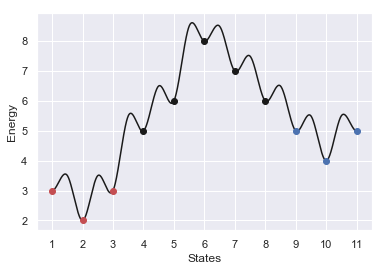

In [9]:
#There are 11 potential energy minima and 10 transition states connecting them
stat_pts = np.zeros((2*len(emin) - 1, )) 
stat_pts[::2] = emin
stat_pts[1:-1:2] = tsdata[:,0]
states = np.arange(1, 11.5, 0.5)
xrange = np.linspace(1, 11, 1000)
#interpolate between the stationary points
cs = CubicSpline(states, stat_pts, bc_type='clamped')
fig, ax = plt.subplots()
ax.plot(xrange, cs(xrange), 'k')
#minima in A set
ax.plot(states[[0, 2, 4]], stat_pts[[0, 2, 4]], 'ro')
#minima in I set
ax.plot(states[6:16:2], stat_pts[6:16:2], 'ko')
#minima in B set
ax.plot(states[[16, 18, 20]], stat_pts[[16, 18, 20]], 'bo')
ax.set_xticks(np.arange(1, 12, 1))
ax.set_xlabel('States')
ax.set_ylabel('Energy')

## Setting up a GT calculation

To set up a graph transformation calculation, we need to specify the nodes that belong to the $\mathcal{A}$ and $\mathcal{B}$ sets, which are the endpoint macrostates of interest. This can be done using the "min.A" and "min.B" files, where the first line indicates the number of nodes in the set, and the subsequent lines contain the IDs (1-indexed) of the nodes belonging to that set. These files are read in by the ``graph_tran.ktn_io.load_ktn_AB()`` function.
 
The GT algorithm requires a branching probability matrix $\textbf{B}$ and a vector specifying the inverse waiting times, or escape rates, of all nodes in the Markov chain. Both of these quantities can be computed from the transition rates (continuous-time) or transition probabilities (discrete-time) connecting the nodes in the Markov chain. There are three possible ways to load in a Markov chain for analysis:

1. Read in a "min.data" and "ts.data" file. These files are meant specifically for creating and analyzing Markov chains from the energy landscape; the format of these files are described in the documentation for the ``graph_tran.ktn_io`` package. The ``graph_tran.ktn_io.load_ktn()`` function will then calculate Arrhenius transition rates from unimolecular rate theory and return the quantities necessary for a GT calculation.


In [26]:
#Specify the temperature at which to compute the Arrhenius transition rates
temp = 1.0
beta = 1./temp
# B is the sparse branching probability matrix (used in GT)
# K is the sparse rate matrix
# N is the number of nodes in the largest connected component
B, K, D, N, u, s, Emin, index_sel = kio.load_ktn(path=Path('KTN_data/chain'), beta=beta)
#escape rates of the nodes (used in GT)
escape_rates = np.ravel(K.sum(axis=0))
#free energies of the nodes, used to compute Boltzmann
BF = beta*u-s
BF -= BF.min()
rho = np.exp(-BF)
rho /= rho.sum()
print("Equilibrium occupation probabilities: ", rho)
#load in the A and B sets
AS, BS = kio.load_ktn_AB(path,index_sel)
#these are boolean arrays with elements = True for the nodes that belong to each set
print("States in A: ", AS)
print("States in B: ", BS)
#compute the MFPTS between A<->B
#nodes in the A and B sets initialized to their local equilibrium occupation probabilities
df = fpt.compute_rates(AS, BS, B, escape_rates=escape_rates, K=K, BF=BF, fullGT=True, dense=False)
df

Equilibrium occupation probabilities:  [0.17803748 0.48395605 0.17803748 0.02409475 0.00886396 0.00119961 0.00326087 0.00886396 0.02409475 0.06549633 0.02409475]
States in A:  [ True  True  True False False False False False False False False]
States in B:  [False False False False False False False False  True  True  True]


,MFPTBA,MFPTAB
0,33524.360033,4889.353724


2. If you already have a transition rate matrix $\textbf{K}$ where $K_{ij}$ are the $i \leftarrow j$ inter-microstate transition rates and the diagonal elements $K_{ii} = \sum_{\gamma} K_{\gamma i}$ are such that the columns sum to zero, then we can use the ``graph_tran.ktn_io.load_CTMC()`` function to obtain the quantities necessary for a GT calculation.


In [16]:
B, escape_rates = kio.load_CTMC(Kmat(temp))
#same calculation as before, but set dense=True since B is dense
df = fpt.compute_rates(AS, BS, B, escape_rates=escape_rates, BF=BF, fullGT=True, dense=True)
df

,MFPTBA,MFPTAB
0,33524.360033,4889.353724


3. If you have a discrete-time transition probability matrix $\textbf{T}(\tau)$ estimated at a lag time $\tau$, we can use the ``graph_tran.ktn_io.load_DTMC()`` function.


In [18]:
#let's create a DTMC corresponding to the CTMC
K = Kmat(temp)
tau = 0.001 #lag time
T = expm(K*tau)
B, escape_rates = kio.load_DTMC(T, tau)
df = fpt.compute_rates(AS, BS, B, escape_rates=escape_rates, BF=BF, fullGT=True, dense=True)
df

,MFPTBA,MFPTAB
0,33524.378925,4889.354673


## Computing Mean First Passage Times with Graph Transformation

Now that we understand how to load in a Markov chain for analysis, let's compute the mean first passage times between the $\mathcal{A}$ and $\mathcal{B}$ sets, defined as
\begin{equation} 
\mathcal{T}_{\mathcal{A}\mathcal{B}} = \frac{1}{\sum_{b \in \mathcal{B}} p_b(0)} \sum_{b \in \mathcal{B}} \frac{p_b(0) \tau^\prime_b}{1-P^\prime_{bb}},
\end{equation}
where $p_b(0)$ is the initial occupation probability of node $b$, and the prime indicates a property of the graph-transformed Markov chain for which nodes of the set $(\mathcal{A}\cup b)^\mathsf{c}$ have been eliminated. The MFPTs in both directions can be obtained from the ``graph_tran.fpt_stats`` module as illustrated below.


In [30]:
#Let's specify an initial condition where all probability density is in nodes 3 and 9
path = Path('KTN_data/chain')
initA = np.array([0., 0., 1.0])
initB = np.array([1.0, 0., 0.])
B, K, D, N, u, s, Emin, index_sel = kio.load_ktn(path=path, beta=1.0)
escape_rates = np.ravel(K.sum(axis=0))
df = fpt.compute_rates(AS, BS, B, escape_rates=escape_rates, initA=initA, initB=initB, fullGT=True)
#Notice that these MFPTs are different from above, where initA and initB were automatically set
# to the local Boltzmann distributions
df

,MFPTBA,MFPTAB
0,33439.651495,4835.687217


We can also define phenomenological rate constants based on expressions from discrete path sampling:

\begin{align}
      k^{ SS}_{ {\mathcal{A}\leftarrow\mathcal{B}}}
      \equiv
      \sum_{ b\in  \mathcal{B}} \frac{C^{\mathcal{A}}_b \widehat{\pi}_b} {\tau_{b}},
%\qquad
\quad
k^{ NSS}_{ {\mathcal{A}\leftarrow\mathcal{B}}} \equiv
               \sum_{ b\in  \mathcal{B}} \frac{
               C^\mathcal{A}_b
               \widehat{\pi}_b
               }
               {
               \tau^\mathcal{I}_b
               },
%\qquad
\quad
k^{F}_{ {\mathcal{A}\leftarrow\mathcal{B}}} \equiv \sum_{ b\in  \mathcal{B}} \frac{ \widehat{\pi}_b }
                                { {\cal T}_{ \mathcal{A} b}},
      \label{kGT}
%\qquad
\quad
k^{*}_{ {\mathcal{A}\leftarrow\mathcal{B}}}
      \equiv \sum_{ b\in  \mathcal{B}} { \widehat{\pi}_b }
                                { {\cal T}_{ \mathcal{A} b}}.
\end{align}
In this hierarchy, $k^{ SS}_{ {\mathcal{A}\leftarrow\mathcal{B}}}$ is the rate when all minima in the intervening region $\mathcal{I}$
are treated in a steady state approximation, and we assume a local equilibrium distribution,  in the source
region $\mathcal{B}$, where $\widehat{\pi}_b=\pi_b/\Pi_\mathcal{B}$ and $\Pi_\mathcal{B} = \sum_{b\in\mathcal{B}} \pi_b$.
$C^\mathcal{A}_b$ is the committor probability that a trajectory leaves minimum $b\in\mathcal{B}$ and reaches $\mathcal{A}$ before
returning to $\mathcal{B}$,
and $\tau_b$ is the escape time from $b$ to any directly connected minimum.
$k^{ SS}_{ {\mathcal{A}\leftarrow\mathcal{B}}}$ neglects contributions to the first passage time from the $\mathcal{I}$ region, which
can lead to a significant systematic error.
$k^{ NSS}_{ {\mathcal{A}\leftarrow\mathcal{B}}}$ results from removing all the $\mathcal{I}$ minima by graph transformation, with $\tau^\mathcal{I}_b$ being the renormalised escape time from $b$ to any member of $\mathcal{A}\cup\mathcal{B}$.
$k^{F}_{ {\mathcal{A}\leftarrow\mathcal{B}}}$ is the rate calculated by removing all nodes in the set ($\mathcal{A}\cup b)^\mathsf{c}$, to obtain
a renormalised escape time $\tau^F_b$ from $b$ to $b\cup\mathcal{A}$, with branching probabilities $P^{\rm F}_{\mathcal{A} b}$ and
$P^{\rm F}_{bb}$, and hence a mean first passage time to $\mathcal{A}$ of
$ {\cal T}_{ \mathcal{A} b}=\tau^{\rm F}_b/P^{\rm F}_{\mathcal{A} b}$.
Finally $k^{*}_{ {\mathcal{A}\leftarrow\mathcal{B}}}$ is just the inverse of the mean first passage time $\mathcal{T}_{\mathcal{A}\mathcal{B}}$.

In [31]:
#Let's compute rates and MFPTs on the Weiss chain for a range of temperatures
invT = np.linspace(0.00001, 10, 10)
df = fpt.rates_cycle(1./invT, path, fullGT=True, MFPTonly=False)
df = df.set_index('T')
df

,MFPTBA,kSSBA,kNSSBA,kQSDBA,k*BA,kFBA,MFPTAB,kSSAB,kNSSAB,kQSDAB,k*AB,kFAB
T,,,,,,,,,,,,
100000.000000,3.667319e+02,5.362667e-03,1.532223e-03,2.805771e-03,2.726788e-03,2.733413e-03,3.591250e+02,5.362774e-03,1.532242e-03,2.842759e-03,2.784546e-03,2.788207e-03
0.899993,6.260415e+04,1.646282e-05,1.436306e-05,1.597408e-05,1.597338e-05,1.597339e-05,7.236868e+03,1.519186e-04,1.045289e-04,1.382759e-04,1.381813e-04,1.381840e-04
0.449998,5.049073e+07,1.982878e-08,1.957385e-08,1.980562e-08,1.980562e-08,1.980562e-08,5.989059e+05,1.688498e-06,1.506625e-06,1.669720e-06,1.669711e-06,1.669711e-06
0.299999,5.811251e+10,1.720875e-11,1.718610e-11,1.720800e-11,1.720800e-11,1.720800e-11,7.404429e+07,1.352234e-08,1.304026e-08,1.350543e-08,1.350543e-08,1.350543e-08
0.225000,7.504874e+13,1.332470e-14,1.332284e-14,1.332467e-14,1.332467e-14,1.332467e-14,1.035147e+10,9.661788e-11,9.548332e-11,9.660463e-11,9.660463e-11,9.660463e-11
0.180000,1.007897e+17,9.921651e-18,9.921502e-18,9.921650e-18,9.921650e-18,9.921650e-18,1.506345e+12,6.638685e-13,6.613020e-13,6.638586e-13,6.638586e-13,6.638586e-13
0.150000,1.371434e+20,7.291636e-21,7.291624e-21,7.291636e-21,7.291636e-21,7.291636e-21,2.221159e+14,4.502160e-15,4.496431e-15,4.502153e-15,4.502153e-15,4.502153e-15
0.128571,1.874204e+23,5.335597e-24,5.335596e-24,5.335597e-24,5.335597e-24,5.335597e-24,3.289449e+16,3.040023e-17,3.038750e-17,3.040023e-17,3.040023e-17,3.040023e-17
0.112500,2.564957e+26,3.898701e-27,3.898701e-27,3.898701e-27,3.898701e-27,3.898701e-27,4.878522e+18,2.049801e-19,2.049518e-19,2.049801e-19,2.049801e-19,2.049801e-19


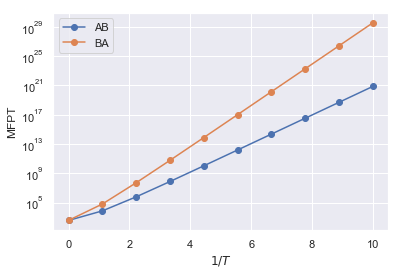

In [32]:
fig, ax = plt.subplots()
ax.plot(invT, df['MFPTAB'], '-o', label='AB')
ax.plot(invT, df['MFPTBA'], '-o', label='BA')
ax.set_xlabel(r'$1/T$')
ax.set_ylabel('MFPT')
ax.set_yscale('log')
plt.legend()

## Extending GT to DTMCs using the Weiss Chain

In [7]:
#Test GT on CTMC using the usual kio method
temp = 1.0
beta = 1./temp
#GT setup
B, K, D, N, u, s, Emin, index_sel = kio.load_ktn(path=path,beta=beta,Emax=None,Nmax=None,screen=False)
D = np.ravel(K.sum(axis=0))
BF = beta*u-s
BF -= BF.min()
AS,BS = kio.load_ktn_AB(path,index_sel) 
df = fpt.compute_rates(AS, BS, B, escape_rates=D, K=K, BF=BF, fullGT=True, dense=False)
df

,MFPTBA,MFPTAB
0,33524.360033,4889.353724


In [18]:
#now re-try CTMC GT with the dense matrices constructed from Kmat
Q = Kmat(temp)
N = Q.shape[0]
K = Q - np.diag(np.diag(Q))
escape_rates = -1*np.diag(Q)
D = np.diag(escape_rates)
B = K@np.diag(1./escape_rates)
df = pgt.compute_rates(AS, BS, BF, B, D, K, fullGT=True, dense=True)
df

,MFPTAB,MFPTBA
0,33524.360033,4889.353724


In [19]:
#now try MFPT for corresponding DTMC
K = Kmat(1.0)
tau = 0.01
T = expm(K*tau)
print(T.sum(axis=0))
D = np.tile(1./tau, N)
print(D)
df = pgt.compute_rates(AS, BS, BF, T, D, fullGT=True, dense=True)
df

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]


,MFPTAB,MFPTBA
0,33524.548927,4889.363216


In [39]:
#It works!!! Try for a range of temperatures
def compare_DTMC_CTMC(betas, lag_time, data_path=Path('KTN_data/32state')):
    tau = lag_time
    dfs = []
    for beta in betas:
        df = pd.DataFrame(columns=['T','MFPTAB_CT', 'MFPTAB_DT', 'MFPTBA_CT', 'MFPTBA_DT'])
        df['T'] = [1./beta]
        #CTMC
        B, K, D, N, u, s, Emin, index_sel = kio.load_ktn(path=data_path,beta=beta,Emax=None,Nmax=None,screen=False)
        Q = K.todense() - D.todense()
        D = np.ravel(K.sum(axis=0))
        BF = beta*u-s
        BF -= BF.min()
        AS,BS = kio.load_ktn_AB(data_path,index_sel) 
        ctdf = fpt.compute_rates(AS, BS, B, escape_rates=D, K=K, BF=BF, fullGT=True, dense=False)
        df['MFPTAB_CT'] = ctdf['MFPTAB']
        df['MFPTBA_CT'] = ctdf['MFPTBA']
        #DTMC
        #K = Kmat(1./beta)
        T = expm(Q*tau)
        D = np.tile(1./tau, N)
        dtdf = fpt.compute_rates(AS, BS, T, escape_rates=D, BF=BF, fullGT=True, dense=True)
        df['MFPTAB_DT'] = dtdf['MFPTAB']
        df['MFPTBA_DT'] = dtdf['MFPTBA']
        dfs.append(df)
    bigdf = pd.concat(dfs)
    return bigdf
        

In [40]:
betas = np.linspace(0.1, 50, 20)
#temps = np.linspace(0.0113, 0.01125, 20)
df = compare_DTMC_CTMC(betas, 0.01)
df = df.set_index('T')
df

,MFPTAB_CT,MFPTAB_DT,MFPTBA_CT,MFPTBA_DT
T,,,,
10.000000,5.514380e+01,5.518926e+01,5.538914e+01,5.543551e+01
0.366795,3.514167e+04,3.514170e+04,5.131033e+04,5.131041e+04
0.186824,2.699433e+07,2.699433e+07,5.131935e+07,5.131935e+07
0.125330,2.548612e+10,2.548612e+10,5.483673e+10,5.483673e+10
0.094293,2.735364e+13,2.735364e+13,6.038415e+13,6.038415e+13
0.075577,3.171458e+16,3.171458e+16,6.848952e+16,6.848952e+16
0.063060,3.839612e+19,3.839612e+19,7.994612e+19,7.994612e+19
0.054100,4.767029e+22,4.767029e+22,9.582811e+22,9.582811e+22
0.047370,6.015769e+25,6.015769e+25,1.176121e+26,1.176121e+26


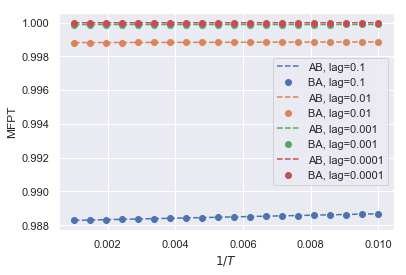

In [47]:
fig, ax = plt.subplots()
colors = sns.color_palette()
betas = np.linspace(0.001, 0.01, 20)
lag_times = [0.1, 0.01, 0.001, 0.0001]
for i,tau in enumerate(lag_times):
    df = compare_DTMC_CTMC(betas, tau)
    #ax.plot(betas, df['MFPTAB_CT'], '--', color=colors[i], label=f'AB, CTMC, lag={tau}')
    ax.plot(betas, df['MFPTAB_CT']/df['MFPTAB_DT'], '--', color=colors[i], label=f'AB, lag={tau}')
    ax.plot(betas, df['MFPTBA_CT']/df['MFPTBA_DT'], 'o', color=colors[i], label=f'BA, lag={tau}')
    #ax.plot(betas, df['MFPTAB_DT'], '-o', color=colors[i], label=f'AB, DTMC, lag={tau}')
ax.set_xlabel(r"$1/T$")
ax.set_ylabel("MFPT")
#ax.set_yscale('log')
plt.legend()

## Model 16-state network

This model network consists of 4 communities with fast transitions within the communities and slow transitions between communities. Due to the separation of timescales, we expect the original formulation of Hummer Szabo to fail, but for the LEA and expressions based on the weighted-MFPTs to be numerically stable.

In [43]:
#load data
data_path = Path('KTN_data/16state')
temp = 10
beta = 1./temp
#GT setup
B, K, D, N, u, s, Emin, index_sel = kio.load_ktn(path=data_path,beta=beta,Emax=None,Nmax=None,screen=False)
D = np.ravel(K.sum(axis=0))
BF = beta*u-s
BF -= BF.min()
AS,BS = kio.load_ktn_AB(data_path,index_sel) 
comms = pgt.read_communities(data_path/'communities.dat', index_sel, screen=True)
for comm in comms:
    if np.all(comms[comm] == AS):
        print(f'Community A: {comm}')
    if np.all(comms[comm] == BS):
        print(f'Community B: {comm}')
ktn = Analyze_KTN(data_path, commdata='communities.dat')
betas = 1./np.linspace(0.1, 10, 10)
df = pgt.rates_cycle(betas, data_path, fullGT=True)
df

Community 0: 4
Community 1: 4
Community 2: 4
Community 3: 4
Community A: 0
Community B: 3


,MFPTAB,MFPTBA,T
0,7.531987e+01,7.473365e+01,10.000000
0,3.364051e+06,2.745739e+06,0.833333
0,1.762975e+11,1.152621e+11,0.434783
0,9.568616e+15,4.880501e+15,0.294118
0,5.333927e+20,2.082014e+20,0.222222
0,3.032460e+25,8.938790e+24,0.178571
0,1.748763e+30,3.858637e+29,0.149254
0,1.018847e+35,1.673352e+34,0.128205
0,5.979606e+39,7.285004e+38,0.112360
0,3.528009e+44,3.182015e+43,0.100000


In [7]:
#compute matrix of inter-microstate MFPTs with GT
temp=10.0
B, K, D, N, u, s, Emin, index_sel = kio.load_ktn(path=data_path,beta=1./temp,Emax=None,Nmax=None,screen=False)
Q = K.todense() - D.todense()
mfpt, pi = pgt.get_intermicrostate_mfpts_GT(temp, data_path)
#compare to result from eigendecomposition
mfpt_eig = ktn.get_MFPT_from_Kmat(Q)
#Kemeny constant
print(pi.reshape(1,N)@mfpt)
print(pi.reshape(1,N)@mfpt_eig)

[[109.19211882 109.19211882 109.19211882 109.19211882 109.19211882 109.19211882 109.19211882 109.19211882 109.19211882 109.19211882 109.19211882 109.19211882
  109.19211882 109.19211882 109.19211882 109.19211882]]
[[109.19211882 109.19211882 109.19211882 109.19211882 109.19211882 109.19211882 109.19211882 109.19211882 109.19211882 109.19211882 109.19211882 109.19211882
  109.19211882 109.19211882 109.19211882 109.19211882]]


In [8]:
#compute weighted-MFPT between communities
commpi = ktn.get_comm_stat_probs(np.log(pi), log=False)
ncomms = len(commpi)
pt = ktn.get_kells_cluster_passage_times(pi, commpi, mfpt)
#Kemeny constant of reduced Markov chain
print(commpi.T@pt)
print(pt)

[75.31880686 75.31880686 75.31880686 75.31880686]
[[  0.          97.90154885  98.73615898  98.65307798]
 [101.21720348   0.         101.21883812 101.13575712]
 [101.2388975  100.40592199   0.         101.15745113]
 [101.49582326 100.66284775 101.49745789   0.        ]]


In [4]:
""" Four different versions of Hummer Szabo."""
ktn.K = Q
ktn.pi = pi
ktn.commpi = commpi
#1) the original (HS)
Rhs_original = ktn.construct_coarse_matrix_Hummer_Szabo(temp)
#2) the KKRA version involving inversion of matrix of inter-microstate mfpts
Rhs_kkra = ktn.hummer_szabo_from_mfpt(temp, GT=False, mfpt=mfpt)
#3) based on inversion of weighted-MFPTs
Rhs_invert = spla.inv(pt)@(np.diag(1./commpi) - np.ones((ncomms,ncomms)))
#4) numerically better version of (3)
Rhs_solve = spla.solve(pt, np.diag(1.0/commpi) - np.ones((ncomms,ncomms)))
print('Original version of Hummer Szabo:')
print(Rhs_original)
print('KKRA version of Hummer Szabo:')
print(Rhs_kkra)
print('Hummer-Szabo from inverting matrix of weighted-MFPTs:')
print(Rhs_invert)
print('Hummer-Szabo from linear solve with matrix of weighted-MFPTs:')
print(Rhs_solve)

#check that Rhs has columns that sum to zero
print(Rhs_solve.sum(axis=0))
#check that commpi is unique right eigenvector of Rhs with zero eigenvalue
print(Rhs_solve@commpi)
#check that detailed balance is satisfied
if not check_detailed_balance(commpi, Rhs_solve):
    print('Detailed balance not satisfied for Rhs.')
if not check_detailed_balance(pi, Q):
    print('Detailed balance not satisfied for K')

[75.31880686 75.31880686 75.31880686 75.31880686]
Original version of Hummer Szabo:
[[-0.02943234  0.01037819  0.01003634  0.01006935]
 [ 0.00987204 -0.03060343  0.0098714   0.00990388]
 [ 0.00978854  0.0101213  -0.02967887  0.00982011]
 [ 0.00977176  0.01010395  0.00977113 -0.02979334]]
KKRA version of Hummer Szabo:
[[-0.02943234  0.01037819  0.01003634  0.01006935]
 [ 0.00987204 -0.03060343  0.0098714   0.00990388]
 [ 0.00978854  0.0101213  -0.02967887  0.00982011]
 [ 0.00977176  0.01010395  0.00977113 -0.02979334]]
Hummer-Szabo from inverting matrix of weighted-MFPTs:
[[-0.02943234  0.01037819  0.01003634  0.01006935]
 [ 0.00987204 -0.03060343  0.0098714   0.00990388]
 [ 0.00978854  0.0101213  -0.02967887  0.00982011]
 [ 0.00977176  0.01010395  0.00977113 -0.02979334]]
Hummer-Szabo from linear solve with matrix of weighted-MFPTs:
[[-0.02943234  0.01037819  0.01003634  0.01006935]
 [ 0.00987204 -0.03060343  0.0098714   0.00990388]
 [ 0.00978854  0.0101213  -0.02967887  0.00982011]
 [

In [5]:
#apply GT on coarse networks to get A<->B MFPTs
rK = Rhs_solve - np.diag(np.diag(Rhs_solve))
escape_rates = -1*np.diag(Rhs_solve)
D = np.diag(escape_rates)
B = rK@np.diag(1./escape_rates)
Acomm = 0
Bcomm = 3
MFPTAB, MFPTBA = pgt.compute_MFPTAB(Acomm, Bcomm, B, D, K=rK, dense=True)
df = pd.DataFrame(columns=['T', 'MFPTAB', 'MFPTBA'])
df['T'] = [temp]
df['MFPTAB'] = [MFPTAB]
df['MFPTBA'] = [MFPTBA]
df

,T,MFPTAB,MFPTBA
0,10.0,98.653078,101.495823


In [8]:
#compare inter-community MFPTs on full vs coarse networks

def compare_HS_LEA(temps, data_path=Path('KTN_data/16state')):
    """ Calculate coarse-grained rate matrices using the Hummer-Szabo and LEA
    methods and compute MFPTAB/BA using NGT to be compared to the rates on the
    full network. """

    dfs = []
    for temp in temps:
        df = pd.DataFrame()
        df['T'] = [temp]
        ktn = Analyze_KTN(data_path, commdata='communities.dat')
        #KTN input
        B, K, D, N, u, s, Emin, index_sel = kio.load_ktn(path=data_path,beta=1./temp,Emax=None,Nmax=None,screen=False)
        Q = K.todense() - D.todense()
        AS, BS = kio.load_ktn_AB(data_path,index_sel) 
        D = np.ravel(K.sum(axis=0))
        BF = beta*u-s
        BF -= BF.min()
        #ktn setup
        mfpt, pi = pgt.get_intermicrostate_mfpts_GT(temp, data_path)
        commpi = ktn.get_comm_stat_probs(np.log(pi), log=False)
        ktn.K = Q
        ktn.pi = pi
        ktn.commpi = commpi
        ncomms = len(commpi)
        #MFPT calculations on full network
        full_df = pgt.compute_rates(AS, BS, BF, B, D, K=K, fullGT=True)
        df['MFPTAB'] = full_df['MFPTAB']
        df['MFPTBA'] = full_df['MFPTBA']
        
        #compute coarse-grained networks: 4 versions of Hummer-Szabo + LEA
        labels = []
        matrices = []
        try:
            Rhs = ktn.construct_coarse_matrix_Hummer_Szabo(temp)
            matrices.append(Rhs)
            labels.append('HS')
        except Exception as e:
            print(f'Hummer Szabo had the following error: {e}')
        try:
            Rhs_kkra = ktn.hummer_szabo_from_mfpt(temp, GT=False, mfpt=mfpt)
            matrices.append(Rhs_kkra)
            labels.append('KKRA')
        except Exception as e:
            print(f'KKRA had the following error: {e}')
        pt = ktn.get_kells_cluster_passage_times(pi, commpi, mfpt)
        try:
            Rhs_invert = spla.inv(pt)@(np.diag(1./commpi) - np.ones((ncomms,ncomms)))
            matrices.append(Rhs_invert)
            labels.append('PTinvert')
        except Exception as e:
            print(f'Inversion of weighted-MFPTs had the following error: {e}')
        try:
            Rhs_solve = spla.solve(pt, np.diag(1.0/commpi) - np.ones((ncomms,ncomms)))
            matrices.append(Rhs_solve)
            labels.append('PTsolve')
        except Exception as e:
            print(f'Linear solve with weighted-MFPTs had the following error: {e}')
        try:
            Rlea = ktn.construct_coarse_rate_matrix_LEA(temp)
            matrices.append(Rlea)
            labels.append('LEA')
        except Exception as e:
            print(f'LEA had the following error: {e}')

        if len(matrices)==0:
            continue

        for i, R in enumerate(matrices):
            """ get A->B and B->A mfpt on coarse network"""
            rK = R - np.diag(np.diag(R))
            escape_rates = -1*np.diag(R)
            D = np.diag(escape_rates)
            B = rK@np.diag(1./escape_rates)
            Acomm = 0
            Bcomm = 3
            MFPTAB, MFPTBA = pgt.compute_MFPTAB(Acomm, Bcomm, B, D, K=rK, dense=True)
            df[f'AB_{labels[i]}'] = [MFPTAB]
            df[f'BA_{labels[i]}'] = [MFPTBA]
        dfs.append(df)
    bigdf = pd.concat(dfs, ignore_index=True, sort=False)
    return bigdf


In [11]:
#some high temperature calculations
invtemps = np.linspace(0.1, 5, 20)
high_temp_df = compare_HS_LEA(1./invtemps)
high_temp_df

HS does not satisfy detailed balance at T=0.25198938992042436


/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:587: RuntimeWarning: divide by zero encountered in true_divide
  MFPTAB = tau_Fs[r_BS]/P_AB
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: divide by zero encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:587: RuntimeWarning: divide by zero encountered in true_divide
  MFPTAB = tau_Fs[r_BS]/P_AB
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: divide by zero encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: invalid value encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:906: RuntimeWarning: invalid value encountered in multiply
  return multiply(a.ravel()[:, newaxis]

HS does not satisfy detailed balance at T=0.2


,T,MFPTAB,MFPTBA,AB_HS,BA_HS,AB_KKRA,BA_KKRA,AB_PTinvert,BA_PTinvert,AB_PTsolve,BA_PTsolve,AB_LEA,BA_LEA
0,10.000000,7.531987e+01,7.473365e+01,9.865308e+01,1.014958e+02,9.865308e+01,1.014958e+02,9.865308e+01,1.014958e+02,9.865308e+01,1.014958e+02,6.605366e+01,6.706320e+01
1,2.794118,8.538807e+02,8.098758e+02,8.347557e+02,8.882819e+02,8.347557e+02,8.882819e+02,8.347557e+02,8.882819e+02,8.347557e+02,8.882819e+02,7.986422e+02,8.444877e+02
2,1.623932,1.067403e+04,9.676486e+03,9.702385e+03,1.071936e+04,9.702385e+03,1.071936e+04,9.702385e+03,1.071936e+04,9.702385e+03,1.071936e+04,9.661948e+03,1.066334e+04
3,1.144578,1.350152e+05,1.169762e+05,1.170031e+05,1.350752e+05,1.170032e+05,1.350752e+05,1.170031e+05,1.350752e+05,1.170031e+05,1.350752e+05,1.169573e+05,1.350031e+05
4,0.883721,1.713578e+06,1.416581e+06,1.416632e+06,1.713689e+06,1.416393e+06,1.713363e+06,1.416609e+06,1.713658e+06,1.416609e+06,1.713658e+06,1.416556e+06,1.713564e+06
5,0.719697,2.180306e+07,1.716634e+07,1.719080e+07,2.183933e+07,1.719708e+07,2.184862e+07,1.716637e+07,2.180317e+07,1.716637e+07,2.180317e+07,1.716631e+07,2.180305e+07
6,0.607029,2.780645e+08,2.081373e+08,1.445968e+08,1.802773e+08,7.644607e+06,2.401664e+06,2.081373e+08,2.780646e+08,2.081373e+08,2.780646e+08,2.081372e+08,2.780645e+08
7,0.524862,3.554152e+09,2.524909e+09,1.546097e+07,1.001370e+08,1.865213e+07,1.112839e+08,2.524909e+09,3.554152e+09,2.524909e+09,3.554152e+09,2.524909e+09,3.554152e+09
8,0.462287,4.552380e+10,3.064488e+10,2.346418e+08,1.549975e+09,2.338879e+08,1.546964e+09,3.064488e+10,4.552380e+10,3.064488e+10,4.552380e+10,3.064488e+10,4.552380e+10
9,0.413043,5.842558e+11,3.721169e+11,2.504797e+09,1.957944e+10,2.504773e+09,1.957930e+10,3.721169e+11,5.842558e+11,3.721169e+11,5.842558e+11,3.721169e+11,5.842558e+11


In [17]:
#some super high temperature calculations (where even original Hummer Szabo won't fail)
invtemps = np.linspace(0.05, 1.5, 20)
super_highT_df = compare_HS_LEA(1./invtemps)
super_highT_df

,T,MFPTAB,MFPTBA,AB_HS,BA_HS,AB_KKRA,BA_KKRA,AB_PTinvert,BA_PTinvert,AB_PTsolve,BA_PTsolve,AB_LEA,BA_LEA
0,20.000000,4.910524e+01,4.900064e+01,7.274031e+01,7.393852e+01,7.274031e+01,7.393852e+01,7.274031e+01,7.393852e+01,7.274031e+01,7.393852e+01,4.074397e+01,4.105243e+01
1,7.916667,9.519899e+01,9.409181e+01,1.181067e+02,1.221117e+02,1.181067e+02,1.221117e+02,1.181067e+02,1.221117e+02,1.181067e+02,1.221117e+02,8.518037e+01,8.683297e+01
2,4.935065,1.924035e+02,1.877078e+02,2.120027e+02,2.215767e+02,2.120027e+02,2.215767e+02,2.120027e+02,2.215767e+02,2.120027e+02,2.215767e+02,1.780897e+02,1.837121e+02
3,3.584906,3.978033e+02,3.827389e+02,4.073188e+02,4.294346e+02,4.073188e+02,4.294346e+02,4.073188e+02,4.294346e+02,4.073188e+02,4.294346e+02,3.723580e+02,3.887738e+02
4,2.814815,8.323083e+02,7.897881e+02,8.146579e+02,8.666132e+02,8.146579e+02,8.666132e+02,8.146579e+02,8.666132e+02,8.146579e+02,8.666132e+02,7.785840e+02,8.229277e+02
5,2.317073,1.752077e+03,1.640161e+03,1.665326e+03,1.789290e+03,1.665326e+03,1.789290e+03,1.665326e+03,1.789290e+03,1.665326e+03,1.789290e+03,1.628069e+03,1.742331e+03
6,1.968912,3.699926e+03,3.417622e+03,3.443087e+03,3.740304e+03,3.443087e+03,3.740304e+03,3.443087e+03,3.740304e+03,3.443087e+03,3.740304e+03,3.404570e+03,3.689802e+03
7,1.711712,7.826394e+03,7.133989e+03,7.159760e+03,7.870217e+03,7.159760e+03,7.870217e+03,7.159760e+03,7.870217e+03,7.159760e+03,7.870217e+03,7.119903e+03,7.815876e+03
8,1.513944,1.657067e+04,1.490565e+04,1.493173e+04,1.661824e+04,1.493174e+04,1.661824e+04,1.493173e+04,1.661824e+04,1.493173e+04,1.661824e+04,1.489045e+04,1.655974e+04
9,1.357143,3.510507e+04,3.115962e+04,3.118602e+04,3.515673e+04,3.118602e+04,3.515673e+04,3.118602e+04,3.515673e+04,3.118602e+04,3.515673e+04,3.114321e+04,3.509372e+04


In [21]:
#some low temperature calculations
invtemps = np.linspace(0.1, 20, 20)
bigdf = compare_HS_LEA(1./invtemps)
bigdf

HS does not satisfy detailed balance at T=0.23312883435582826


/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: invalid value encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:402: RuntimeWarning: invalid value encountered in greater
  nBd[Bd>0.99] = Bnd[Bd>0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:403: RuntimeWarning: invalid value encountered in less
  nBd[Bd<0.99] = 1.0-Bd[Bd<0.99]


HS does not satisfy detailed balance at T=0.1873767258382643


/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:587: RuntimeWarning: divide by zero encountered in true_divide
  MFPTAB = tau_Fs[r_BS]/P_AB


HS does not satisfy detailed balance at T=0.15663643858202805


/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: divide by zero encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: invalid value encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:906: RuntimeWarning: invalid value encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:402: RuntimeWarning: invalid value encountered in greater
  nBd[Bd>0.99] = Bnd[Bd>0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:403: RuntimeWarning: invalid value encountered in less
  nBd[Bd<0.99] = 1.0-Bd[Bd<0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:579: RuntimeWarning: divide by zero encountered in true_divide
  tau_Fs 

HS does not satisfy detailed balance at T=0.13456090651558075


/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: divide by zero encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:906: RuntimeWarning: invalid value encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:402: RuntimeWarning: invalid value encountered in greater
  nBd[Bd>0.99] = Bnd[Bd>0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:403: RuntimeWarning: invalid value encountered in less
  nBd[Bd<0.99] = 1.0-Bd[Bd<0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:579: RuntimeWarning: divide by zero encountered in true_divide
  tau_Fs = 1./rD
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: divide by zero encountered in true_divide
  Bxj = np.ravel(Bxj.flatten()

HS does not satisfy detailed balance at T=0.09457441513190643


/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: divide by zero encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: divide by zero encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA


HS does not satisfy detailed balance at T=0.08605072463768117


/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:587: RuntimeWarning: divide by zero encountered in true_divide
  MFPTAB = tau_Fs[r_BS]/P_AB
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: divide by zero encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:587: RuntimeWarning: divide by zero encountered in true_divide
  MFPTAB = tau_Fs[r_BS]/P_AB


HS does not satisfy detailed balance at T=0.07893643539675946


/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: divide by zero encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: divide by zero encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: invalid value encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:906: RuntimeWarning: invalid value encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:402: RuntimeWarning: invalid value encountered in greater
  nBd[Bd>0.99] = Bnd[Bd>0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:403: RuntimeWarning: invalid value encountered in less
  nBd[Bd<0.99

HS does not satisfy detailed balance at T=0.07290867229470453


/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: invalid value encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:402: RuntimeWarning: invalid value encountered in greater
  nBd[Bd>0.99] = Bnd[Bd>0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:403: RuntimeWarning: invalid value encountered in less
  nBd[Bd<0.99] = 1.0-Bd[Bd<0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: divide by zero encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:906: RuntimeWarning: invalid value encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:402: RuntimeWarning: invalid value encountered in greater
  nBd[Bd>0.99] 

HS does not satisfy detailed balance at T=0.06773618538324422


/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: divide by zero encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: divide by zero encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:587: RuntimeWarning: divide by zero encountered in true_divide
  MFPTAB = tau_Fs[r_BS]/P_AB
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:587: RuntimeWarning: divide by zero encountered in true_divide
  MFPTAB = tau_Fs[r_BS]/P_AB


HS does not satisfy detailed balance at T=0.05931938807368092


/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: divide by zero encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: divide by zero encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:587: RuntimeWarning: divide by zero encountered in true_divide
  MFPTAB = tau_Fs[r_BS]/P_AB


HS does not satisfy detailed balance at T=0.05584950029394474


/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: invalid value encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:402: RuntimeWarning: invalid value encountered in greater
  nBd[Bd>0.99] = Bnd[Bd>0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:403: RuntimeWarning: invalid value encountered in less
  nBd[Bd<0.99] = 1.0-Bd[Bd<0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: divide by zero encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: invalid value encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:906: RuntimeWarning: invalid value encountered in multiply
  return multiply(a.ravel()[:, newaxis], 

,T,MFPTAB,MFPTBA,AB_HS,BA_HS,AB_KKRA,BA_KKRA,AB_PTinvert,BA_PTinvert,AB_PTsolve,BA_PTsolve,AB_LEA,BA_LEA
0,10.000000,7.531987e+01,7.473365e+01,9.865308e+01,1.014958e+02,9.865308e+01,1.014958e+02,9.865308e+01,1.014958e+02,9.865308e+01,1.014958e+02,6.605366e+01,6.706320e+01
1,0.871560,2.002180e+06,1.650315e+06,1.650330e+06,2.002243e+06,1.650135e+06,2.001976e+06,1.650343e+06,2.002261e+06,1.650343e+06,2.002261e+06,1.650290e+06,2.002166e+06
2,0.455635,6.221733e+10,4.160263e+10,3.136705e+08,2.115106e+09,3.126672e+08,2.110998e+09,4.160263e+10,6.221733e+10,4.160263e+10,6.221733e+10,4.160263e+10,6.221733e+10
3,0.308442,1.997325e+15,1.057117e+15,4.402928e+12,6.046305e+13,4.418791e+12,6.036011e+13,1.057117e+15,1.997325e+15,1.057117e+15,1.997325e+15,1.057117e+15,1.997325e+15
4,0.233129,6.575642e+19,2.704750e+19,-4.141116e+14,4.385493e+16,NaN,NaN,2.704750e+19,6.575642e+19,2.704750e+19,6.575642e+19,2.704750e+19,6.575642e+19
5,0.187377,2.206250e+24,6.961856e+23,-7.079552e+14,5.973050e+16,inf,2.604619e+17,6.961856e+23,2.206250e+24,6.961856e+23,2.206250e+24,6.961856e+23,2.206250e+24
6,0.156636,7.506444e+28,1.801142e+28,NaN,NaN,-9.650776e+14,-1.277119e+17,1.801142e+28,7.506444e+28,1.801142e+28,7.506444e+28,1.801142e+28,7.506444e+28
7,0.134561,2.580125e+33,4.680275e+32,NaN,NaN,4.914731e+14,2.733389e+18,4.680275e+32,2.580125e+33,4.680275e+32,2.580125e+33,4.680275e+32,2.580125e+33
8,0.117939,8.934540e+37,1.220715e+37,NaN,NaN,inf,-2.090601e+17,1.220715e+37,8.934540e+37,1.220715e+37,8.934540e+37,1.220715e+37,8.934540e+37
9,0.104972,3.110699e+42,3.194025e+41,2.703359e+14,5.604978e+17,-2.719218e+14,-1.054200e+18,3.194025e+41,3.110699e+42,3.194025e+41,3.110699e+42,3.194025e+41,3.110699e+42


In [65]:
params = {'axes.grid': True, 'axes.titlesize': 20.0,
          'axes.linewidth': 0.75, 'backend': 'pdf','axes.labelsize':
          16,'legend.fontsize': 14,
          'xtick.labelsize': 12,'ytick.labelsize': 12,'text.usetex':
          False,'figure.figsize': [7, 5],
          #'font.family': 'serif', 'font.serif': 'Computer Modern Roman',
          'mathtext.fontset': 'cm', 'savefig.format': 'pdf',
          'xtick.bottom':True, 'xtick.major.pad': 5, 'xtick.major.size': 5,
          'xtick.major.width': 0.5,
          'ytick.left':True, 'ytick.right':False, 'ytick.major.pad': 5,
          'ytick.major.size': 5, 'ytick.major.width': 0.5,
          'ytick.minor.right':False, 'lines.linewidth':2}
plt.rcParams.update(params)

In [4]:
def plot_ratios_16state(df, log=True, excludeHS=False):
    """Plot ratio of MFPT on coarse-grained networks to exact MFPT on full network."""
    colors = sns.color_palette("Dark2", 5)
    df.replace([np.inf, -np.inf], np.nan)
    df2= df.sort_values('T')
    symbols = ['-s', '-o', '--^', '-x', '--x']
    rates = ['LEA', 'KKRA', 'HS', 'PTinvert', 'PTsolve']
    if excludeHS:
        symbols = ['-s', '-o', '--^']
        rates = ['LEA', 'PTinvert', 'PTsolve']
    labels = rates
    denom = 'MFPT'
    #first plot A<-B direction
    fig, (ax, ax2) = plt.subplots(1, 2, figsize=[10, 4])
    for j, CG in enumerate(rates):
        #then only plot HSK for temperatures that are not NaN
        df2CG = df2[-df2[f'BA_{CG}'].isna()]
        ax.plot(1./df2CG['T'], df2CG[f'BA_{CG}']/df2CG[f'{denom}BA'],
                symbols[j], label=labels[j], color=colors[j], linewidth=1,
                markersize=4)
    ax.set_xlabel(r'$1/T$')
    if log:
        ax.set_yscale('log')
    ax.set_ylabel('Ratio MFPTBA')
    ax.legend(frameon=True)
    for j, CG in enumerate(rates):
        #then only plot HSK for temperatures that are not NaN
        df2CG = df2[-df2[f'AB_{CG}'].isna()]
        ax2.plot(1./df2CG['T'], df2CG[f'AB_{CG}']/df2CG[f'{denom}AB'],
                symbols[j], label=labels[j], color=colors[j], linewidth=1,
                markersize=4)
    ax2.set_xlabel(r'$1/T$')
    ax2.set_ylabel('Ratio MFPTAB')
    if log:
        ax2.set_yscale('log')
    ax2.legend(frameon=True)
    fig.tight_layout()
    #fig.subplots_adjust(left=0.12, top=0.97, right=0.99, bottom=0.11,
    #                    wspace=0.325)

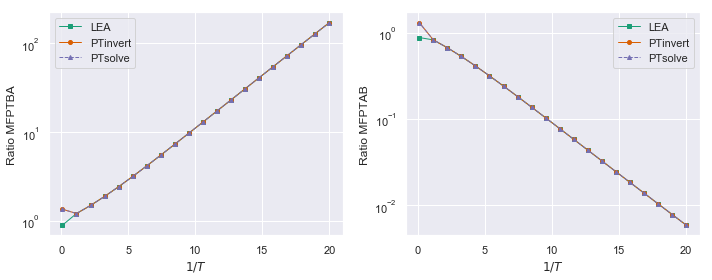

In [23]:
plot_ratios_16state(bigdf, excludeHS=True)

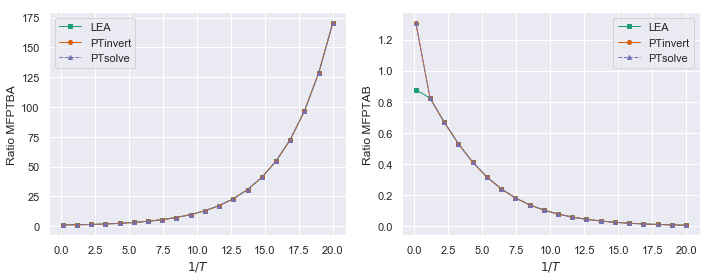

In [25]:
plot_ratios_16state(bigdf, excludeHS=True, log=False)

In [3]:
def plot_mfpts_16state(df, excludeHS=False, log=True):
    """Plot MFPTs computed on coarse-grained networks against true MFPT from full network."""
    colors = sns.color_palette("Dark2", 5)
    df.replace([np.inf, -np.inf], np.nan)
    df2= df.sort_values('T')
    symbols = ['-s', '-o', '--^', '-x', '--x']
    rates = ['LEA', 'KKRA', 'HS', 'PTinvert', 'PTsolve']
    if excludeHS:
        rates = ['LEA', 'PTinvert', 'PTsolve']
        symbols = ['-s', '-o', '--^']
    labels = rates
    denom = 'MFPT'
    #first plot A<-B direction
    fig, (ax, ax2) = plt.subplots(1, 2, figsize=[10, 4])
    ax.plot(1./df2['T'], df2['MFPTBA'], '-', color='k', label='Exact', lw=1, markersize=4)
    for j, CG in enumerate(rates):
        #then only plot HSK for temperatures that are not NaN
        df2CG = df2[-df2[f'BA_{CG}'].isna()]
        ax.plot(1./df2CG['T'], df2CG[f'BA_{CG}'],
                symbols[j], label=labels[j], color=colors[j], linewidth=1,
                markersize=4)
    ax.set_xlabel(r'$1/T$')
    if log:
        ax.set_yscale('log')
    ax.set_ylabel('MFPTBA')
    ax.legend(frameon=True)
    ax2.plot(1./df2['T'], df2['MFPTAB'], '-', color='k', label='Exact', lw=1, markersize=4)
    for j, CG in enumerate(rates):
        #then only plot HSK for temperatures that are not NaN
        df2CG = df2[-df2[f'AB_{CG}'].isna()]
        ax2.plot(1./df2CG['T'], df2CG[f'AB_{CG}'],
                symbols[j], label=labels[j], color=colors[j], linewidth=1,
                markersize=4)
    ax2.set_xlabel(r'$1/T$')
    ax2.set_ylabel('MFPTAB')
    if log:
        ax2.set_yscale('log')
    ax2.legend(frameon=True)
    fig.tight_layout()

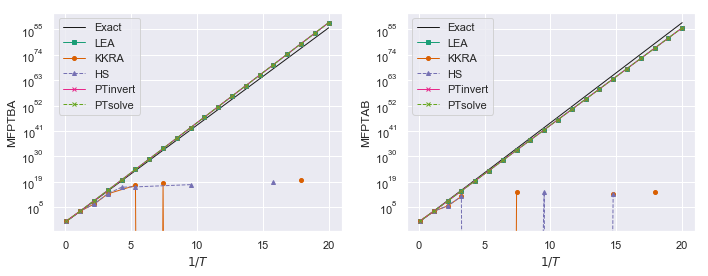

In [50]:
plot_mfpts_16state(bigdf)

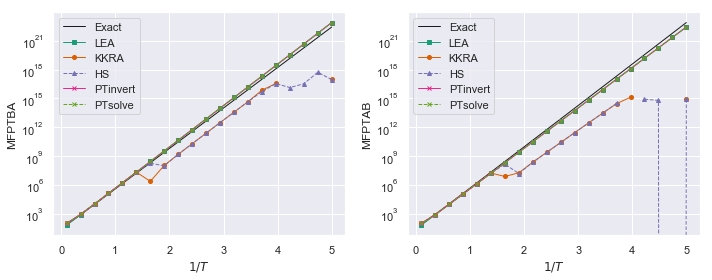

In [12]:
plot_mfpts_16state(high_temp_df)

HS and KKRA break down at around beta = 1.5. The other two versions of Hummer Szabo retain numerical precision but are identical to the LEA rates. All three of these methods deviate systematically from the true MFPTs in the low temperature regime. 

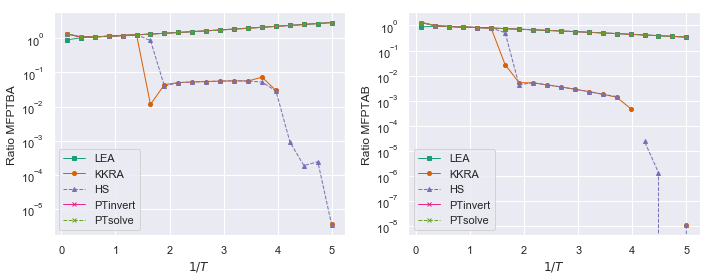

In [15]:
plot_ratios_16state(high_temp_df)

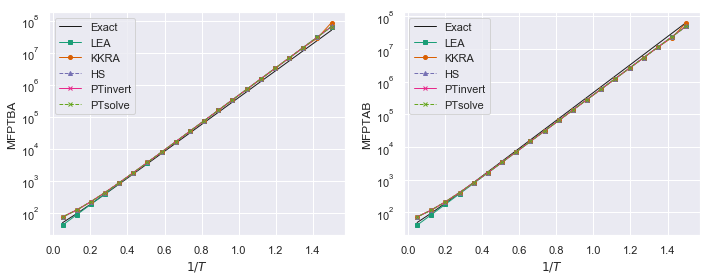

In [18]:
plot_mfpts_16state(super_highT_df)

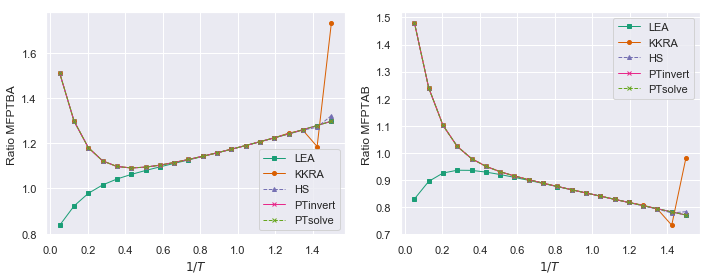

In [20]:
plot_ratios_16state(super_highT_df, log=False)

Even in the super high-temperature regime, all methods are relatively the same. If anything, LEA seems to work better than Hummer-Szabo since they both deviate at the highest temperatures.

In [66]:
# why is KKRA so bad? Let's plot the condition number of the 4-dimensional matrix that it inverts.
#condition number of weighted-MFPT matrix vs. 1/T
data_path = Path('KTN_data/16state')
invtemps = np.linspace(1, 20, 20)
#temp = 1./76
cond_weighted_MFPT = []
cond_KKRA = []
cond_fund_mat = []
cond_HS = []
cond_Rhs_2ndterm = []
cond_Rkkra_2ndterm = []
cond_Rhs = []
cond_Rkkra = []
for temp in 1./invtemps:
    B, K, D, N, u, s, Emin, index_sel = kio.load_ktn(path=data_path,beta=beta,Emax=None,Nmax=None,screen=False)
    Q = K.todense() - D.todense()
    mfpt, pi = pgt.get_intermicrostate_mfpts_GT(temp, data_path)
    #compute weighted-MFPT between communities
    commpi = ktn.get_comm_stat_probs(np.log(pi), log=False)
    pt = ktn.get_kells_cluster_passage_times(pi, commpi, mfpt)
    cond_weighted_MFPT.append(np.linalg.cond(pt))
    #KKRA calculation
    N = len(ktn.communities)
    n = len(pi)
    D_N = np.diag(commpi)
    D_n = np.diag(pi)
    #construct clustering matrix M from community assignments
    M = np.zeros((n, N))
    for ci in ktn.communities:
        col = np.zeros((n,))
        comm_idxs = np.array(ktn.communities[ci]) - 1
        col[comm_idxs] = 1.0
        M[:, ci-1] = col

    Pi_col = commpi.reshape((N, 1))
    pi_col = pi.reshape((n, 1))
    KKRAmat = Pi_col@Pi_col.T + M.T@D_n@mfpt@pi_col@Pi_col.T - M.T@D_n@mfpt@D_n@M
    cond_KKRA.append(np.linalg.cond(KKRAmat))
    RKKRA = D_N@spla.inv(KKRAmat)
    cond_Rkkra_2ndterm.append(np.linalg.cond(RKKRA))
    RKKRA = Pi_col@np.ones((1,N)) - RKKRA
    cond_Rkkra.append(np.linalg.cond(RKKRA))
    #fundamental matrix (in original Hummer-Szabo expression)
    fund_mat = pi_col@np.ones((1,n)) - Q
    cond_fund_mat.append(np.linalg.cond(fund_mat))
    HSmat = M.T@spla.inv(fund_mat)@D_n@M
    R_HS = D_N@spla.inv(HSmat)
    cond_HS.append(np.linalg.cond(HSmat))
    cond_Rhs_2ndterm.append(np.linalg.cond(R_HS))
    R_HS = Pi_col@np.ones((1,N)) - R_HS
    cond_Rhs.append(np.linalg.cond(R_HS))


In [67]:
textwidth = 6.47699
params = {'axes.edgecolor': 'black', 
                  'axes.facecolor':'white', 
                  'axes.grid': False, 
                  'axes.linewidth': 0.5, 
                  'backend': 'ps',
                  'savefig.format': 'ps',
                  'axes.titlesize': 11,
                  'axes.labelsize': 9,
                  'legend.fontsize': 9,
                  'xtick.labelsize': 8,
                  'ytick.labelsize': 8,
                  'text.usetex': True,
                  'figure.figsize': [7, 5],
                  'font.family': 'sans-serif', 
                  #'mathtext.fontset': 'cm', 
                  'xtick.bottom':True,
                  'xtick.top': False,
                  'xtick.direction': 'out',
                  'xtick.major.pad': 3, 
                  'xtick.major.size': 3,
                  'xtick.minor.bottom': False,
                  'xtick.major.width': 0.2,

                  'ytick.left':True, 
                  'ytick.right':False, 
                  'ytick.direction':'out',
                  'ytick.major.pad': 3,
                  'ytick.major.size': 3, 
                  'ytick.major.width': 0.2,
                  'ytick.minor.right':False, 
                  'lines.linewidth':2}
plt.rcParams.update(params)

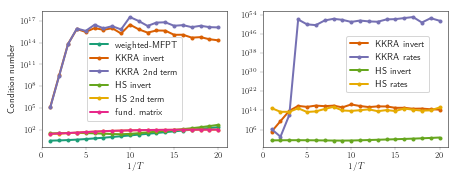

In [79]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(textwidth, textwidth/2.5))
colors = sns.color_palette("Dark2", 6)
ax.plot(invtemps, cond_weighted_MFPT, 'o-', markersize=3, color=colors[0], label='weighted-MFPT')
ax.plot(invtemps, cond_KKRA, 'o-', markersize=3, color=colors[1], label='KKRA invert')
ax.plot(invtemps, cond_Rkkra_2ndterm, 'o-', markersize=3, color=colors[2], label='KKRA 2nd term')
ax.plot(invtemps, cond_HS, 'o-', markersize=3, color=colors[4], label='HS invert')
ax.plot(invtemps, cond_Rhs_2ndterm, 'o-', markersize=3, color=colors[5], label='HS 2nd term')
ax.plot(invtemps, cond_fund_mat, 'o-', markersize=3, color=colors[3], label='fund. matrix')
ax.legend()
ax.set_xlabel(r"$1/T$")
ax.set_ylabel("Condition number")
ax.set_yscale('log')
ax2.plot(invtemps, cond_KKRA, 'o-', markersize=3, color=colors[1], label='KKRA invert')
ax2.plot(invtemps, cond_Rkkra, 'o-', markersize=3, color=colors[2], label='KKRA rates')
ax2.plot(invtemps, cond_HS, 'o-', markersize=3, color=colors[4], label='HS invert')
ax2.plot(invtemps, cond_Rhs, 'o-', markersize=3, color=colors[5], label='HS rates')
ax2.legend(loc=(0.45, 0.4))
ax2.set_xlabel(r"$1/T$")
ax2.set_yscale('log')
fig.tight_layout()
plt.savefig('plots/condition_numbers_16state.pdf')

## Asymmetric 16-state chain

In the above example, all six inter-community edges were weighted equally. In this modified chain, we consider a more asymmetric network where 3 of the 6 edges (0<->1, 1<->3, and 0<->3) have a higher TS energy and therefore represent slower transitions than the other 3 edges.

![title](16-state-network.png)

As a result, we suspect that even the `PTinvert` and `PTsolve` versions of Hummer Szabo will become numerically unstable in the low temperature regime.

In [13]:
#load data
data_path = Path('KTN_data/16state/asymmetric')
temp = 10
beta = 1./temp
#GT setup
B, K, D, N, u, s, Emin, index_sel = kio.load_ktn(path=data_path,beta=beta,Emax=None,Nmax=None,screen=False)
D = np.ravel(K.sum(axis=0))
BF = beta*u-s
BF -= BF.min()
AS,BS = kio.load_ktn_AB(data_path,index_sel) 
comms = pgt.read_communities(data_path/'communities.dat', index_sel, screen=True)
for comm in comms:
    if np.all(comms[comm] == AS):
        print(f'Community A: {comm}')
    if np.all(comms[comm] == BS):
        print(f'Community B: {comm}')
ktn = Analyze_KTN(data_path, commdata='communities.dat')
betas = 1./np.linspace(0.1, 10, 10)
df = pgt.rates_cycle(betas, data_path, fullGT=True)
df

Community 0: 4
Community 1: 4
Community 2: 4
Community 3: 4
Community A: 0
Community B: 3


,MFPTAB,MFPTBA,T
0,2.764102e+02,2.727968e+02,10.000000
0,1.345616e+07,1.098288e+07,0.833333
0,7.051900e+11,4.610484e+11,0.434783
0,3.827447e+16,1.952200e+16,0.294118
0,2.133571e+21,8.328056e+20,0.222222
0,1.212984e+26,3.575516e+25,0.178571
0,6.995052e+30,1.543455e+30,0.149254
0,4.075386e+35,6.693407e+34,0.128205
0,2.391842e+40,2.914002e+39,0.112360
0,1.411204e+45,1.272806e+44,0.100000


In [5]:
#compute matrix of inter-microstate MFPTs with GT
temp=10.0
B, K, D, N, u, s, Emin, index_sel = kio.load_ktn(path=data_path,beta=1./temp,Emax=None,Nmax=None,screen=False)
Q = K.todense() - D.todense()
mfpt, pi = pgt.get_intermicrostate_mfpts_GT(temp, data_path)
print(mfpt.shape)
#compute weighted-MFPT between communities
commpi = ktn.get_comm_stat_probs(np.log(pi), log=False)
ncomms = len(commpi)
pt = ktn.get_kells_cluster_passage_times(pi, commpi, mfpt)
#Kemeny constant of reduced Markov chain
print(pt)
print(commpi.T@pt)

(16, 16)
[[  0.         294.98061473 230.45024188 296.71626079]
 [303.29165618   0.         235.43061442 301.69663333]
 [102.57598746  99.24531855   0.         100.98096461]
 [302.58615902 299.25549011 234.72511726   0.        ]]
[175.05500641 175.05500641 175.05500641 175.05500641]


In [6]:
""" Four different versions of Hummer Szabo."""
ktn.K = Q
ktn.pi = pi
ktn.commpi = commpi
#1) the original (HS)
Rhs_original = ktn.construct_coarse_matrix_Hummer_Szabo(temp)
#2) the KKRA version involving inversion of matrix of inter-microstate mfpts
Rhs_kkra = ktn.hummer_szabo_from_mfpt(temp, GT=False, mfpt=mfpt)
#3) based on inversion of weighted-MFPTs
Rhs_invert = spla.inv(pt)@(np.diag(1./commpi) - np.ones((ncomms,ncomms)))
#4) numerically better version of (3)
Rhs_solve = spla.solve(pt, np.diag(1.0/commpi) - np.ones((ncomms,ncomms)))
print('Original version of Hummer Szabo:')
print(Rhs_original)
print('KKRA version of Hummer Szabo:')
print(Rhs_kkra)
print('Hummer-Szabo from inverting matrix of weighted-MFPTs:')
print(Rhs_invert)
print('Hummer-Szabo from linear solve with matrix of weighted-MFPTs:')
print(Rhs_solve)

#check that Rhs has columns that sum to zero
print(Rhs_solve.sum(axis=0))
#check that commpi is unique right eigenvector of Rhs with zero eigenvalue
print(Rhs_solve@commpi)
#check that detailed balance is satisfied
if not check_detailed_balance(commpi, Rhs_solve):
    print('Detailed balance not satisfied for Rhs.')
if not check_detailed_balance(pi, Q):
    print('Detailed balance not satisfied for K')

Original version of Hummer Szabo:
[[-0.01193526  0.00117955  0.00994048  0.00115224]
 [ 0.00112202 -0.01248467  0.00988581  0.0011459 ]
 [ 0.00969505  0.01013607 -0.02967827  0.00990136]
 [ 0.00111818  0.00116905  0.00985198 -0.0121995 ]]
KKRA version of Hummer Szabo:
[[-0.01193526  0.00117955  0.00994048  0.00115224]
 [ 0.00112202 -0.01248467  0.00988581  0.0011459 ]
 [ 0.00969505  0.01013607 -0.02967827  0.00990136]
 [ 0.00111818  0.00116905  0.00985198 -0.0121995 ]]
Hummer-Szabo from inverting matrix of weighted-MFPTs:
[[-0.01193526  0.00117955  0.00994048  0.00115224]
 [ 0.00112202 -0.01248467  0.00988581  0.0011459 ]
 [ 0.00969505  0.01013607 -0.02967827  0.00990136]
 [ 0.00111818  0.00116905  0.00985198 -0.0121995 ]]
Hummer-Szabo from linear solve with matrix of weighted-MFPTs:
[[-0.01193526  0.00117955  0.00994048  0.00115224]
 [ 0.00112202 -0.01248467  0.00988581  0.0011459 ]
 [ 0.00969505  0.01013607 -0.02967827  0.00990136]
 [ 0.00111818  0.00116905  0.00985198 -0.0121995 ]]


HS does not satisfy detailed balance at T=0.23312883435582826
HS does not satisfy detailed balance at T=0.1873767258382643
HS does not satisfy detailed balance at T=0.15663643858202805


/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: divide by zero encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: invalid value encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:906: RuntimeWarning: invalid value encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:402: RuntimeWarning: invalid value encountered in greater
  nBd[Bd>0.99] = Bnd[Bd>0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:403: RuntimeWarning: invalid value encountered in less
  nBd[Bd<0.99] = 1.0-Bd[Bd<0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:579: RuntimeWarning: divide by zero encountered in true_divide
  tau_Fs 

HS does not satisfy detailed balance at T=0.13456090651558075


/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: divide by zero encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:906: RuntimeWarning: invalid value encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:402: RuntimeWarning: invalid value encountered in greater
  nBd[Bd>0.99] = Bnd[Bd>0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:403: RuntimeWarning: invalid value encountered in less
  nBd[Bd<0.99] = 1.0-Bd[Bd<0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:579: RuntimeWarning: divide by zero encountered in true_divide
  tau_Fs = 1./rD
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:587: RuntimeWarning: divide by zero encountered in true_divide
  MFPTAB = tau_Fs[r_BS]/P_AB


HS does not satisfy detailed balance at T=0.09457441513190643


/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: divide by zero encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: divide by zero encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA


HS does not satisfy detailed balance at T=0.08605072463768117


/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:587: RuntimeWarning: divide by zero encountered in true_divide
  MFPTAB = tau_Fs[r_BS]/P_AB
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: divide by zero encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:587: RuntimeWarning: divide by zero encountered in true_divide
  MFPTAB = tau_Fs[r_BS]/P_AB


HS does not satisfy detailed balance at T=0.07893643539675946


/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: divide by zero encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: divide by zero encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: invalid value encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:906: RuntimeWarning: invalid value encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:402: RuntimeWarning: invalid value encountered in greater
  nBd[Bd>0.99] = Bnd[Bd>0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:403: RuntimeWarning: invalid value encountered in less
  nBd[Bd<0.99

HS does not satisfy detailed balance at T=0.07290867229470453


/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: invalid value encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:402: RuntimeWarning: invalid value encountered in greater
  nBd[Bd>0.99] = Bnd[Bd>0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:403: RuntimeWarning: invalid value encountered in less
  nBd[Bd<0.99] = 1.0-Bd[Bd<0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: divide by zero encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:906: RuntimeWarning: invalid value encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:402: RuntimeWarning: invalid value encountered in greater
  nBd[Bd>0.99] 

HS does not satisfy detailed balance at T=0.06773618538324422


/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: divide by zero encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: divide by zero encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:587: RuntimeWarning: divide by zero encountered in true_divide
  MFPTAB = tau_Fs[r_BS]/P_AB
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:587: RuntimeWarning: divide by zero encountered in true_divide
  MFPTAB = tau_Fs[r_BS]/P_AB


HS does not satisfy detailed balance at T=0.05931938807368092


/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: divide by zero encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: divide by zero encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:587: RuntimeWarning: divide by zero encountered in true_divide
  MFPTAB = tau_Fs[r_BS]/P_AB


HS does not satisfy detailed balance at T=0.05584950029394474


/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: invalid value encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:402: RuntimeWarning: invalid value encountered in greater
  nBd[Bd>0.99] = Bnd[Bd>0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:403: RuntimeWarning: invalid value encountered in less
  nBd[Bd<0.99] = 1.0-Bd[Bd<0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: divide by zero encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: invalid value encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:906: RuntimeWarning: invalid value encountered in multiply
  return multiply(a.ravel()[:, newaxis], 

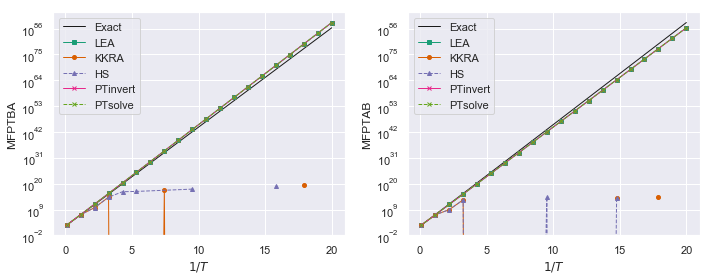

In [13]:
#some low temperature calculations
invtemps = np.linspace(0.1, 20, 20)
midtemp_df = compare_HS_LEA(1./invtemps, data_path=Path('KTN_data/16state/asymmetric'))
plot_mfpts_16state(midtemp_df)

In [16]:
invtemps = np.linspace(60, 80, 20)
lowtemp_df = compare_HS_LEA(1./invtemps)
plot_mfpts_16state(lowtemp_df, excludeHS=True)

Hummer Szabo had the following error: singular matrix


/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: divide by zero encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:587: RuntimeWarning: divide by zero encountered in true_divide
  MFPTAB = tau_Fs[r_BS]/P_AB


Hummer Szabo had the following error: singular matrix


/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: divide by zero encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: invalid value encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:906: RuntimeWarning: invalid value encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:402: RuntimeWarning: invalid value encountered in greater
  nBd[Bd>0.99] = Bnd[Bd>0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:403: RuntimeWarning: invalid value encountered in less
  nBd[Bd<0.99] = 1.0-Bd[Bd<0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:579: RuntimeWarning: divide by zero encountered in true_divide
  tau_Fs 

Hummer Szabo had the following error: singular matrix


/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: divide by zero encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA


Hummer Szabo had the following error: singular matrix


/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:587: RuntimeWarning: divide by zero encountered in true_divide
  MFPTAB = tau_Fs[r_BS]/P_AB


Hummer Szabo had the following error: singular matrix


/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: divide by zero encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: invalid value encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:906: RuntimeWarning: invalid value encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:402: RuntimeWarning: invalid value encountered in greater
  nBd[Bd>0.99] = Bnd[Bd>0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:403: RuntimeWarning: invalid value encountered in less
  nBd[Bd<0.99] = 1.0-Bd[Bd<0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:579: RuntimeWarning: divide by zero encountered in true_divide
  tau_Fs 

Hummer Szabo had the following error: singular matrix
Hummer Szabo had the following error: singular matrix


/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: divide by zero encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:906: RuntimeWarning: invalid value encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:402: RuntimeWarning: invalid value encountered in greater
  nBd[Bd>0.99] = Bnd[Bd>0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:403: RuntimeWarning: invalid value encountered in less
  nBd[Bd<0.99] = 1.0-Bd[Bd<0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:579: RuntimeWarning: divide by zero encountered in true_divide
  tau_Fs = 1./rD


Hummer Szabo had the following error: singular matrix


/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:587: RuntimeWarning: divide by zero encountered in true_divide
  MFPTAB = tau_Fs[r_BS]/P_AB


Hummer Szabo had the following error: singular matrix


/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: divide by zero encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: invalid value encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:906: RuntimeWarning: invalid value encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:402: RuntimeWarning: invalid value encountered in greater
  nBd[Bd>0.99] = Bnd[Bd>0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:403: RuntimeWarning: invalid value encountered in less
  nBd[Bd<0.99] = 1.0-Bd[Bd<0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:579: RuntimeWarning: divide by zero encountered in true_divide
  tau_Fs 

Hummer Szabo had the following error: singular matrix


/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: divide by zero encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: invalid value encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:906: RuntimeWarning: invalid value encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:402: RuntimeWarning: invalid value encountered in greater
  nBd[Bd>0.99] = Bnd[Bd>0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:403: RuntimeWarning: invalid value encountered in less
  nBd[Bd<0.99] = 1.0-Bd[Bd<0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:579: RuntimeWarning: divide by zero encountered in true_divide
  tau_Fs 

Hummer Szabo had the following error: singular matrix


/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: divide by zero encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: invalid value encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:906: RuntimeWarning: invalid value encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:402: RuntimeWarning: invalid value encountered in greater
  nBd[Bd>0.99] = Bnd[Bd>0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:403: RuntimeWarning: invalid value encountered in less
  nBd[Bd<0.99] = 1.0-Bd[Bd<0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:579: RuntimeWarning: divide by zero encountered in true_divide
  tau_Fs 

/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:587: RuntimeWarning: overflow encountered in true_divide
  MFPTAB = tau_Fs[r_BS]/P_AB
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: overflow encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:587: RuntimeWarning: overflow encountered in true_divide
  MFPTAB = tau_Fs[r_BS]/P_AB
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: overflow encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:587: RuntimeWarning: overflow encountered in true_divide
  MFPTAB = tau_Fs[r_BS]/P_AB
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: overflow encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partial

Hummer Szabo had the following error: singular matrix
KKRA had the following error: array must not contain infs or NaNs
Inversion of weighted-MFPTs had the following error: array must not contain infs or NaNs
Linear solve with weighted-MFPTs had the following error: array must not contain infs or NaNs


/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:587: RuntimeWarning: overflow encountered in true_divide
  MFPTAB = tau_Fs[r_BS]/P_AB
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: overflow encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:587: RuntimeWarning: overflow encountered in true_divide
  MFPTAB = tau_Fs[r_BS]/P_AB
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: overflow encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:587: RuntimeWarning: overflow encountered in true_divide
  MFPTAB = tau_Fs[r_BS]/P_AB
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: overflow encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partial

/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: overflow encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:587: RuntimeWarning: overflow encountered in true_divide
  MFPTAB = tau_Fs[r_BS]/P_AB
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: overflow encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:587: RuntimeWarning: overflow encountered in true_divide
  MFPTAB = tau_Fs[r_BS]/P_AB
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: overflow encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:587: RuntimeWarning: overflow encountered in true_divide
  MFPTAB = tau_Fs[r_BS]/P_AB
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partial

/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:587: RuntimeWarning: overflow encountered in true_divide
  MFPTAB = tau_Fs[r_BS]/P_AB
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: overflow encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:587: RuntimeWarning: overflow encountered in true_divide
  MFPTAB = tau_Fs[r_BS]/P_AB
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: overflow encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:587: RuntimeWarning: overflow encountered in true_divide
  MFPTAB = tau_Fs[r_BS]/P_AB
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: overflow encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partial

Hummer Szabo had the following error: singular matrix
KKRA had the following error: array must not contain infs or NaNs
Inversion of weighted-MFPTs had the following error: array must not contain infs or NaNs
Linear solve with weighted-MFPTs had the following error: array must not contain infs or NaNs


/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:587: RuntimeWarning: overflow encountered in true_divide
  MFPTAB = tau_Fs[r_BS]/P_AB
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: overflow encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:587: RuntimeWarning: overflow encountered in true_divide
  MFPTAB = tau_Fs[r_BS]/P_AB
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: overflow encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:587: RuntimeWarning: overflow encountered in true_divide
  MFPTAB = tau_Fs[r_BS]/P_AB
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: overflow encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partial

/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:587: RuntimeWarning: overflow encountered in true_divide
  MFPTAB = tau_Fs[r_BS]/P_AB
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: overflow encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:587: RuntimeWarning: overflow encountered in true_divide
  MFPTAB = tau_Fs[r_BS]/P_AB
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: overflow encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:587: RuntimeWarning: overflow encountered in true_divide
  MFPTAB = tau_Fs[r_BS]/P_AB
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: overflow encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partial

/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: overflow encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:587: RuntimeWarning: overflow encountered in true_divide
  MFPTAB = tau_Fs[r_BS]/P_AB
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: overflow encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:587: RuntimeWarning: overflow encountered in true_divide
  MFPTAB = tau_Fs[r_BS]/P_AB
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: overflow encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:587: RuntimeWarning: overflow encountered in true_divide
  MFPTAB = tau_Fs[r_BS]/P_AB
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partial

Hummer Szabo had the following error: singular matrix
KKRA had the following error: array must not contain infs or NaNs
Inversion of weighted-MFPTs had the following error: array must not contain infs or NaNs
Linear solve with weighted-MFPTs had the following error: array must not contain infs or NaNs


/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:587: RuntimeWarning: overflow encountered in true_divide
  MFPTAB = tau_Fs[r_BS]/P_AB
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: divide by zero encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:587: RuntimeWarning: overflow encountered in true_divide
  MFPTAB = tau_Fs[r_BS]/P_AB
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: divide by zero encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:587: RuntimeWarning: overflow encountered in true_divide
  MFPTAB = tau_Fs[r_BS]/P_AB
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: divide by zero encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_

/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: invalid value encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:906: RuntimeWarning: invalid value encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:402: RuntimeWarning: invalid value encountered in greater
  nBd[Bd>0.99] = Bnd[Bd>0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:403: RuntimeWarning: invalid value encountered in less
  nBd[Bd<0.99] = 1.0-Bd[Bd<0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: divide by zero encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: invalid value encountered in true_divide
  Bxj = np.

/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:403: RuntimeWarning: invalid value encountered in less
  nBd[Bd<0.99] = 1.0-Bd[Bd<0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: divide by zero encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: invalid value encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:906: RuntimeWarning: invalid value encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:402: RuntimeWarning: invalid value encountered in greater
  nBd[Bd>0.99] = Bnd[Bd>0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:403: RuntimeWarning: invalid value encountered in less
  nBd[Bd<0.99] = 1

Hummer Szabo had the following error: singular matrix
KKRA had the following error: array must not contain infs or NaNs
Inversion of weighted-MFPTs had the following error: array must not contain infs or NaNs
Linear solve with weighted-MFPTs had the following error: array must not contain infs or NaNs


/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: divide by zero encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:587: RuntimeWarning: overflow encountered in true_divide
  MFPTAB = tau_Fs[r_BS]/P_AB
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: divide by zero encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:587: RuntimeWarning: overflow encountered in true_divide
  MFPTAB = tau_Fs[r_BS]/P_AB
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: divide by zero encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:587: RuntimeWarning: overflow encountered in true_divide
  MFPTAB = tau_Fs[r_BS]/P_AB
/Users/deepti/Documents/Wales/git-remotes/KTN_

/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: divide by zero encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:587: RuntimeWarning: overflow encountered in true_divide
  MFPTAB = tau_Fs[r_BS]/P_AB
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: divide by zero encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:587: RuntimeWarning: overflow encountered in true_divide
  MFPTAB = tau_Fs[r_BS]/P_AB
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: divide by zero encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:587: RuntimeWarning: overflow encountered in true_divide
  MFPTAB = tau_Fs[r_BS]/P_AB
/Users/deepti/Documents/Wales/git-remotes/KTN_

/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:403: RuntimeWarning: invalid value encountered in less
  nBd[Bd<0.99] = 1.0-Bd[Bd<0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: divide by zero encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: invalid value encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:906: RuntimeWarning: invalid value encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:402: RuntimeWarning: invalid value encountered in greater
  nBd[Bd>0.99] = Bnd[Bd>0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:403: RuntimeWarning: invalid value encountered in less
  nBd[Bd<0.99] = 1

/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:654: RuntimeWarning: divide by zero encountered in double_scalars
  T_Ba[a] = tau_Fs[rf_s][0]/P_Ba
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:654: RuntimeWarning: divide by zero encountered in double_scalars
  T_Ba[a] = tau_Fs[rf_s][0]/P_Ba
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:654: RuntimeWarning: overflow encountered in double_scalars
  T_Ba[a] = tau_Fs[rf_s][0]/P_Ba
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:654: RuntimeWarning: overflow encountered in double_scalars
  T_Ba[a] = tau_Fs[rf_s][0]/P_Ba
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:654: RuntimeWarning: overflow encountered in double_scalars
  T_Ba[a] = tau_Fs[rf_s][0]/P_Ba
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:654: RuntimeWarning: overflow encountered in double_scalars
  T_Ba[a] = tau_Fs[rf_s][0]/P_Ba
/Users/dee

Hummer Szabo had the following error: singular matrix
KKRA had the following error: array must not contain infs or NaNs
Inversion of weighted-MFPTs had the following error: array must not contain infs or NaNs
Linear solve with weighted-MFPTs had the following error: array must not contain infs or NaNs


/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: divide by zero encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: invalid value encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:906: RuntimeWarning: invalid value encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:402: RuntimeWarning: invalid value encountered in greater
  nBd[Bd>0.99] = Bnd[Bd>0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:403: RuntimeWarning: invalid value encountered in less
  nBd[Bd<0.99] = 1.0-Bd[Bd<0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: divide by zero encountered in true_divide
  Bxj = np

/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: invalid value encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:906: RuntimeWarning: invalid value encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:402: RuntimeWarning: invalid value encountered in greater
  nBd[Bd>0.99] = Bnd[Bd>0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:403: RuntimeWarning: invalid value encountered in less
  nBd[Bd<0.99] = 1.0-Bd[Bd<0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: divide by zero encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: invalid value encountered in true_divide
  Bxj = np.

/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:403: RuntimeWarning: invalid value encountered in less
  nBd[Bd<0.99] = 1.0-Bd[Bd<0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: divide by zero encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: invalid value encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:906: RuntimeWarning: invalid value encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:402: RuntimeWarning: invalid value encountered in greater
  nBd[Bd>0.99] = Bnd[Bd>0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:403: RuntimeWarning: invalid value encountered in less
  nBd[Bd<0.99] = 1

Hummer Szabo had the following error: singular matrix
KKRA had the following error: array must not contain infs or NaNs
Inversion of weighted-MFPTs had the following error: array must not contain infs or NaNs
Linear solve with weighted-MFPTs had the following error: array must not contain infs or NaNs


/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:402: RuntimeWarning: invalid value encountered in greater
  nBd[Bd>0.99] = Bnd[Bd>0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:403: RuntimeWarning: invalid value encountered in less
  nBd[Bd<0.99] = 1.0-Bd[Bd<0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: invalid value encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:402: RuntimeWarning: invalid value encountered in greater
  nBd[Bd>0.99] = Bnd[Bd>0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:403: RuntimeWarning: invalid value encountered in less
  nBd[Bd<0.99] = 1.0-Bd[Bd<0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: invalid value encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/Documents/Wales/gi

/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: invalid value encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:906: RuntimeWarning: invalid value encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:402: RuntimeWarning: invalid value encountered in greater
  nBd[Bd>0.99] = Bnd[Bd>0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:403: RuntimeWarning: invalid value encountered in less
  nBd[Bd<0.99] = 1.0-Bd[Bd<0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: divide by zero encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: invalid value encountered in true_divide
  Bxj = np.

/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:403: RuntimeWarning: invalid value encountered in less
  nBd[Bd<0.99] = 1.0-Bd[Bd<0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: divide by zero encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: invalid value encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:906: RuntimeWarning: invalid value encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:402: RuntimeWarning: invalid value encountered in greater
  nBd[Bd>0.99] = Bnd[Bd>0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:403: RuntimeWarning: invalid value encountered in less
  nBd[Bd<0.99] = 1

Hummer Szabo had the following error: singular matrix
KKRA had the following error: array must not contain infs or NaNs
Inversion of weighted-MFPTs had the following error: array must not contain infs or NaNs
Linear solve with weighted-MFPTs had the following error: array must not contain infs or NaNs


/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:402: RuntimeWarning: invalid value encountered in greater
  nBd[Bd>0.99] = Bnd[Bd>0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:403: RuntimeWarning: invalid value encountered in less
  nBd[Bd<0.99] = 1.0-Bd[Bd<0.99]
/Users/deepti/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in true_divide
/Users/deepti/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in matmul
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:310: RuntimeWarning: divide by zero encountered in true_divide
  iD = 1.0/np.ravel(D)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:402: RuntimeWarning: invalid value encountered in greater
  nBd[Bd>0.99] = Bnd[Bd>0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:403: RuntimeWarning: invalid value en

IndexError: index 4 is out of bounds for axis 0 with size 4

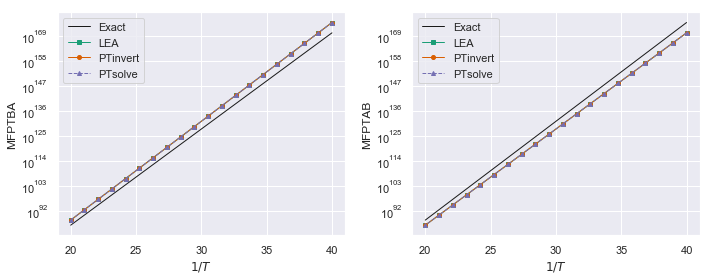

In [14]:
#condition number of weighted-MFPT matrix vs. 1/T
data_path = Path('KTN_data/16state/asymmetric')
invtemps = np.linspace(1, 76, 20)
#temp = 1./76
cond_numbers = []
for temp in 1./invtemps:
    mfpt, pi = pgt.get_intermicrostate_mfpts_GT(temp, data_path)
    print(mfpt.shape)
    #compute weighted-MFPT between communities
    commpi = ktn.get_comm_stat_probs(np.log(pi), log=False)
    pt = ktn.get_kells_cluster_passage_times(pi, commpi, mfpt)
    cond_numbers.append(np.linalg.cond(pt))

(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)


/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: overflow encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: overflow encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: overflow encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: overflow encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: overflow encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: overflow encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partial

/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: overflow encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: overflow encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: overflow encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: overflow encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: overflow encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: overflow encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partial

(16, 16)


/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: divide by zero encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:587: RuntimeWarning: overflow encountered in true_divide
  MFPTAB = tau_Fs[r_BS]/P_AB
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: divide by zero encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:587: RuntimeWarning: overflow encountered in true_divide
  MFPTAB = tau_Fs[r_BS]/P_AB
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: divide by zero encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:587: RuntimeWarning: overflow encountered in true_divide
  MFPTAB = tau_Fs[r_BS]/P_AB
/Users/deepti/Documents/Wales/git-remotes/KTN_

/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:403: RuntimeWarning: invalid value encountered in less
  nBd[Bd<0.99] = 1.0-Bd[Bd<0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: divide by zero encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: invalid value encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:906: RuntimeWarning: invalid value encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:402: RuntimeWarning: invalid value encountered in greater
  nBd[Bd>0.99] = Bnd[Bd>0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:403: RuntimeWarning: invalid value encountered in less
  nBd[Bd<0.99] = 1

(16, 16)


/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:403: RuntimeWarning: invalid value encountered in less
  nBd[Bd<0.99] = 1.0-Bd[Bd<0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: divide by zero encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: invalid value encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:906: RuntimeWarning: invalid value encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:402: RuntimeWarning: invalid value encountered in greater
  nBd[Bd>0.99] = Bnd[Bd>0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:403: RuntimeWarning: invalid value encountered in less
  nBd[Bd<0.99] = 1

In [17]:
#condition number of weighted-MFPT matrix vs. 1/T
data_path = Path('KTN_data/16state')
invtemps = np.linspace(1, 76, 20)
#temp = 1./76
cond_numbers2 = []
for temp in 1./invtemps:
    mfpt, pi = pgt.get_intermicrostate_mfpts_GT(temp, data_path)
    print(mfpt.shape)
    #compute weighted-MFPT between communities
    commpi = ktn.get_comm_stat_probs(np.log(pi), log=False)
    pt = ktn.get_kells_cluster_passage_times(pi, commpi, mfpt)
    cond_numbers2.append(np.linalg.cond(pt))

(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)


/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: overflow encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: overflow encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: overflow encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: overflow encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: overflow encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: overflow encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partial

/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: overflow encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:587: RuntimeWarning: overflow encountered in true_divide
  MFPTAB = tau_Fs[r_BS]/P_AB
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: overflow encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:587: RuntimeWarning: overflow encountered in true_divide
  MFPTAB = tau_Fs[r_BS]/P_AB
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: overflow encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:587: RuntimeWarning: overflow encountered in true_divide
  MFPTAB = tau_Fs[r_BS]/P_AB
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partial

(16, 16)


/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:587: RuntimeWarning: overflow encountered in true_divide
  MFPTAB = tau_Fs[r_BS]/P_AB
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: divide by zero encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:587: RuntimeWarning: overflow encountered in true_divide
  MFPTAB = tau_Fs[r_BS]/P_AB
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: divide by zero encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:587: RuntimeWarning: overflow encountered in true_divide
  MFPTAB = tau_Fs[r_BS]/P_AB
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: divide by zero encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA
/Users/deepti/Documents/Wales/git-remotes/KTN_

/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:403: RuntimeWarning: invalid value encountered in less
  nBd[Bd<0.99] = 1.0-Bd[Bd<0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: divide by zero encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: invalid value encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:906: RuntimeWarning: invalid value encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:402: RuntimeWarning: invalid value encountered in greater
  nBd[Bd>0.99] = Bnd[Bd>0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:403: RuntimeWarning: invalid value encountered in less
  nBd[Bd<0.99] = 1

(16, 16)


/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:403: RuntimeWarning: invalid value encountered in less
  nBd[Bd<0.99] = 1.0-Bd[Bd<0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: divide by zero encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: invalid value encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:906: RuntimeWarning: invalid value encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:402: RuntimeWarning: invalid value encountered in greater
  nBd[Bd>0.99] = Bnd[Bd>0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:403: RuntimeWarning: invalid value encountered in less
  nBd[Bd<0.99] = 1

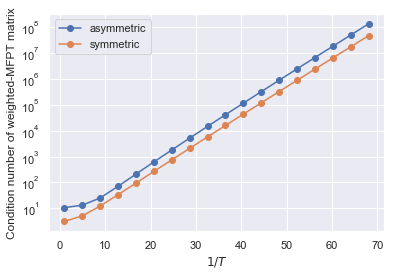

In [21]:
fig, ax = plt.subplots()
ax.plot(invtemps, cond_numbers, 'o-', label='asymmetric')
ax.plot(invtemps, cond_numbers2, 'o-', label='symmetric')
ax.set_xlabel(r"$1/T$")
ax.set_ylabel("Condition number of weighted-MFPT matrix")
ax.set_yscale('log')
plt.legend()

In [3]:
%debug pgt.get_intermicrostate_mfpts_GT(temp, data_path)

NOTE: Enter 'c' at the ipdb>  prompt to continue execution.
> <string>(1)<module>()

ipdb> s
> <string>(2)<module>()

ipdb> s
--Call--
> /Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py(540)get_intermicrostate_mfpts_GT()
    538     return B, D, Q, N, BF, communities
    539 
--> 540 def get_intermicrostate_mfpts_GT(temp, data_path, **kwargs):
    541     """Compute matrix of inter-microstate MFPTs with GT."""
    542     beta = 1./temp

ipdb> s
> /Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py(542)get_intermicrostate_mfpts_GT()
    540 def get_intermicrostate_mfpts_GT(temp, data_path, **kwargs):
    541     """Compute matrix of inter-microstate MFPTs with GT."""
--> 542     beta = 1./temp
    543     #GT setup
    544     B, K, D, N, u, s, Emin, index_sel = kio.load_mat(path=data_path,beta=beta,Emax=None,Nmax=None,screen=False)

ipdb> n
> /Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py(544)get_intermicrostate_mfpts_GT()


ipdb> n
> /Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/ktn_io.py(127)load_mat()
    125     #make minima indices 0-indexed
    126     TSD['I'] = TSD['I']-1
--> 127     TSD['F'] = TSD['F']-1
    128     #number of minima
    129     N = max(TSD['I'].max()+1,TSD['F'].max()+1)

ipdb> n
> /Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/ktn_io.py(129)load_mat()
    127     TSD['F'] = TSD['F']-1
    128     #number of minima
--> 129     N = max(TSD['I'].max()+1,TSD['F'].max()+1)
    130 
    131     if not Nmax is None:

ipdb> n
> /Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/ktn_io.py(131)load_mat()
    129     N = max(TSD['I'].max()+1,TSD['F'].max()+1)
    130 
--> 131     if not Nmax is None:
    132         N = min(Nmax,N)
    133     #select out minima < Emax and < Nmax

ipdb> N
16
ipdb> TSD.shape
(22,)
ipdb> GSD.shape
(16,)
ipdb> b
ipdb> n
> /Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/ktn_io.py(134)load_mat()
    132         N = min(Nmax,N)

ipdb> TSD.shape
(22,)
ipdb> GSD.shape
(16,)
ipdb> n
> /Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/ktn_io.py(144)load_mat()
    142     #print("N,N_TS:",GSD.size,TSD.size)
    143     Emin = GSD['E'].min().copy()
--> 144     Smin = min(GSD['S'].min().copy(),TSD['S'].min().copy())
    145     GSD['E'] -= Emin
    146     TSD['E'] -= Emin

ipdb> n
> /Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/ktn_io.py(145)load_mat()
    143     Emin = GSD['E'].min().copy()
    144     Smin = min(GSD['S'].min().copy(),TSD['S'].min().copy())
--> 145     GSD['E'] -= Emin
    146     TSD['E'] -= Emin
    147     GSD['S'] -= Smin

ipdb> n
> /Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/ktn_io.py(146)load_mat()
    144     Smin = min(GSD['S'].min().copy(),TSD['S'].min().copy())
    145     GSD['E'] -= Emin
--> 146     TSD['E'] -= Emin
    147     GSD['S'] -= Smin
    148     TSD['S'] -= Smin

ipdb> n
> /Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/ktn_io.py(147)l

ipdb> n
> /Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/ktn_io.py(156)load_mat()
    154     du = np.hstack((TSD['E']-GSD[TSD['I']]['E'],TSD['E']-GSD[TSD['F']]['E']))
    155     #(fvibmin - fvibts)/2
--> 156     ds = np.hstack((GSD[TSD['I']]['S']-TSD['S'],GSD[TSD['F']]['S']-TSD['S']))/2.0
    157     #ordermin/(orderts*2pi)
    158     dc = np.hstack((GSD[TSD['I']]['DD']/TSD['DD'],GSD[TSD['F']]['DD']/TSD['DD']))/2.0/np.pi

ipdb> n
> /Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/ktn_io.py(158)load_mat()
    156     ds = np.hstack((GSD[TSD['I']]['S']-TSD['S'],GSD[TSD['F']]['S']-TSD['S']))/2.0
    157     #ordermin/(orderts*2pi)
--> 158     dc = np.hstack((GSD[TSD['I']]['DD']/TSD['DD'],GSD[TSD['F']]['DD']/TSD['DD']))/2.0/np.pi
    159     ds += np.log(dc)
    160 

ipdb> n
> /Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/ktn_io.py(159)load_mat()
    157     #ordermin/(orderts*2pi)
    158     dc = np.hstack((GSD[TSD['I']]['DD']/TSD['DD'],GSD[TSD['F']]['DD'

ipdb> n
> /Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/ktn_io.py(169)load_mat()
    167     #this is the rates, but data is horizontally stacked
    168     data[:] = np.exp(-beta*du+ds)
--> 169     data[i==f] *= 2.0
    170     fNi = f*N+i
    171     fNi_u = np.unique(fNi)

ipdb> data.shape
(44,)
ipdb> n
> /Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/ktn_io.py(170)load_mat()
    168     data[:] = np.exp(-beta*du+ds)
    169     data[i==f] *= 2.0
--> 170     fNi = f*N+i
    171     fNi_u = np.unique(fNi)
    172     d_u = np.r_[[data[fNi==fi_ind].sum() for fi_ind in fNi_u]]

ipdb> n
> /Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/ktn_io.py(171)load_mat()
    169     data[i==f] *= 2.0
    170     fNi = f*N+i
--> 171     fNi_u = np.unique(fNi)
    172     d_u = np.r_[[data[fNi==fi_ind].sum() for fi_ind in fNi_u]]
    173     if discon:

ipdb> n
> /Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/ktn_io.py(172)load_mat()
    170     fNi = f*N+i
 

ipdb> n
> /Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/ktn_io.py(178)load_mat()
    176     i_u = fNi_u%N
    177     K = csr_matrix((d_u,(f_u,i_u)),shape=(N,N))
--> 178     if discon:
    179         DU = csr_matrix((d_du,(f_u,i_u)),shape=(N,N))
    180 

ipdb> K.shape
(16, 16)
ipdb> n
> /Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/ktn_io.py(182)load_mat()
    180 
    181     """ connected components """
--> 182     K.eliminate_zeros()
    183     #nc is number of connected components,
    184     # cc is list of labels of size K

ipdb> n
> /Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/ktn_io.py(185)load_mat()
    183     #nc is number of connected components,
    184     # cc is list of labels of size K
--> 185     nc,cc = csgraph.connected_components(K)
    186     sum = np.zeros(nc,int)
    187     mc = 0

ipdb> K.shape
(16, 16)
ipdb> K
<16x16 sparse matrix of type '<class 'numpy.float64'>'
	with 32 stored elements in Compressed Sparse Row format

ipdb> n
> /Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/ktn_io.py(190)load_mat()
    188     for j in range(nc):
    189         #count number of minima in each connected component
--> 190         sum[j] = (cc==j).sum()
    191     #select largest connected component (value of j for which sum[j] is
    192     # greatest)

ipdb> n
> /Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/ktn_io.py(188)load_mat()
    186     sum = np.zeros(nc,int)
    187     mc = 0
--> 188     for j in range(nc):
    189         #count number of minima in each connected component
    190         sum[j] = (cc==j).sum()

ipdb> n
> /Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/ktn_io.py(190)load_mat()
    188     for j in range(nc):
    189         #count number of minima in each connected component
--> 190         sum[j] = (cc==j).sum()
    191     #select largest connected component (value of j for which sum[j] is
    192     # greatest)

ipdb> n
> /Users/deepti/Documents/Wales/gi

ipdb> K
<4x4 sparse matrix of type '<class 'numpy.float64'>'
	with 8 stored elements in Compressed Sparse Row format>
ipdb> q


In [4]:
%debug kio.load_ktn(path=data_path, beta=80., screen=True)

NOTE: Enter 'c' at the ipdb>  prompt to continue execution.
> <string>(1)<module>()

ipdb> s
> <string>(2)<module>()

ipdb> s
> <string>(3)<module>()

ipdb> s
--Call--
> /Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/ktn_io.py(97)load_mat()
     95     return A_states,B_states
     96 
---> 97 def load_mat(path='../data/LJ38/raw/',Nmax=None,Emax=None,beta=1.0,screen=False,discon=False):
     98     """ Load in min.data and ts.data files, calculate rates, and find connected
     99     components.

ipdb> s
> /Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/ktn_io.py(118)load_mat()
    116     """
    117 
--> 118     GSD = np.loadtxt(os.path.join(path,'min.data'), \
    119                         dtype={'names': ('E','S','DD','RX','RY','RZ'),\
    120                             'formats': (float,float,int,float,float,float)})

ipdb> n
> /Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/ktn_io.py(119)load_mat()
    117 
    118     GSD = np.loadtxt(os.path.join

ipdb> n
> /Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/ktn_io.py(134)load_mat()
    132         N = min(Nmax,N)
    133     #select out minima < Emax and < Nmax
--> 134     sels = (TSD['I']<N) * (TSD['F']<N) * (TSD['I']!=TSD['F'])
    135     if not Emax is None:
    136         sels *= GSD['E'][TSD['I']]<Emax

ipdb> n
> /Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/ktn_io.py(135)load_mat()
    133     #select out minima < Emax and < Nmax
    134     sels = (TSD['I']<N) * (TSD['F']<N) * (TSD['I']!=TSD['F'])
--> 135     if not Emax is None:
    136         sels *= GSD['E'][TSD['I']]<Emax
    137         sels *= GSD['E'][TSD['F']]<Emax

ipdb> n
> /Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/ktn_io.py(139)load_mat()
    137         sels *= GSD['E'][TSD['F']]<Emax
    138         sels *= TSD['E']<Emax
--> 139     TSD = TSD[sels]
    140     GSD = GSD[:N]
    141     #re-scale energies so Emin = 0, Smin=0

ipdb> n
> /Users/deepti/Documents/Wales/git-remote

ipdb> n
> /Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/ktn_io.py(147)load_mat()
    145     GSD['E'] -= Emin
    146     TSD['E'] -= Emin
--> 147     GSD['S'] -= Smin
    148     TSD['S'] -= Smin
    149 

ipdb> n
> /Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/ktn_io.py(148)load_mat()
    146     TSD['E'] -= Emin
    147     GSD['S'] -= Smin
--> 148     TSD['S'] -= Smin
    149 
    150     """ Calculate rates """

ipdb> 
> /Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/ktn_io.py(151)load_mat()
    149 
    150     """ Calculate rates """
--> 151     i = np.hstack((TSD['I'],TSD['F']))
    152     f = np.hstack((TSD['F'],TSD['I']))
    153     #(emin - ets)

ipdb> 
> /Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/ktn_io.py(152)load_mat()
    150     """ Calculate rates """
    151     i = np.hstack((TSD['I'],TSD['F']))
--> 152     f = np.hstack((TSD['F'],TSD['I']))
    153     #(emin - ets)
    154     du = np.hstack((TSD['E']-GSD[TSD['I']]['E

ipdb> 
> /Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/ktn_io.py(159)load_mat()
    157     #ordermin/(orderts*2pi)
    158     dc = np.hstack((GSD[TSD['I']]['DD']/TSD['DD'],GSD[TSD['F']]['DD']/TSD['DD']))/2.0/np.pi
--> 159     ds += np.log(dc)
    160 
    161     s = GSD['S']/2.0 + np.log(GSD['DD'])

ipdb> 
> /Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/ktn_io.py(161)load_mat()
    159     ds += np.log(dc)
    160 
--> 161     s = GSD['S']/2.0 + np.log(GSD['DD'])
    162 
    163     """+ds Fill matricies: K_ij = rate(j->i), K_ii==0. iD_jj = 1/(sum_iK_ij) """

ipdb> 
> /Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/ktn_io.py(164)load_mat()
    162 
    163     """+ds Fill matricies: K_ij = rate(j->i), K_ii==0. iD_jj = 1/(sum_iK_ij) """
--> 164     data = np.zeros(du.shape)
    165     if discon:
    166         ddu = du.copy()

ipdb> 
> /Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/ktn_io.py(165)load_mat()
    163     """+ds Fill matricies:

ipdb> 
> /Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/ktn_io.py(173)load_mat()
    171     fNi_u = np.unique(fNi)
    172     d_u = np.r_[[data[fNi==fi_ind].sum() for fi_ind in fNi_u]]
--> 173     if discon:
    174         d_du = np.r_[[ddu[fNi==fi_ind].sum() for fi_ind in fNi_u]]
    175     f_u = fNi_u//N

ipdb> 
> /Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/ktn_io.py(175)load_mat()
    173     if discon:
    174         d_du = np.r_[[ddu[fNi==fi_ind].sum() for fi_ind in fNi_u]]
--> 175     f_u = fNi_u//N
    176     i_u = fNi_u%N
    177     K = csr_matrix((d_u,(f_u,i_u)),shape=(N,N))

ipdb> 
> /Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/ktn_io.py(176)load_mat()
    174         d_du = np.r_[[ddu[fNi==fi_ind].sum() for fi_ind in fNi_u]]
    175     f_u = fNi_u//N
--> 176     i_u = fNi_u%N
    177     K = csr_matrix((d_u,(f_u,i_u)),shape=(N,N))
    178     if discon:

ipdb> 
> /Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/ktn_io.py(177

ipdb> n
> /Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/ktn_io.py(185)load_mat()
    183     #nc is number of connected components,
    184     # cc is list of labels of size K
--> 185     nc,cc = csgraph.connected_components(K)
    186     sum = np.zeros(nc,int)
    187     mc = 0

ipdb> K
<16x16 sparse matrix of type '<class 'numpy.float64'>'
	with 32 stored elements in Compressed Sparse Row format>
ipdb> K.todense()
matrix([[0.0000000e+00, 6.7614658e-19, 0.0000000e+00, 6.7614658e-19, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [6.7614658e-19, 0.0000000e+00, 6.7614658e-19, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 6.7614658e-19, 0.0000000

## Model 32-state network

Since the LEA worked so well for the 16-state network, we now introduce some more complexity with a 32-state model. Each community has 8 nodes, including 1 attractor node, 4 internal nodes, and 3 boundary nodes. We also introduce two different timescales for inter-community transitions (some that are fast and some that are slow).

In [28]:
data_path = Path('KTN_data/32state')
temp = 10
beta = 1./temp
#GT setup
B, K, D, N, u, s, Emin, index_sel = kio.load_ktn(path=data_path,beta=beta,Emax=None,Nmax=None,screen=True)
D = np.ravel(K.sum(axis=0))
BF = beta*u-s
BF -= BF.min()
AS,BS = kio.load_ktn_AB(data_path,index_sel) 
comms = pgt.read_communities(data_path/'communities.dat', index_sel, screen=True)
for comm in comms:
    if np.all(comms[comm] == AS):
        print(f'Community A: {comm}')
    if np.all(comms[comm] == BS):
        print(f'Community B: {comm}')
ktn = Analyze_KTN(data_path, commdata='communities.dat')
betas = 1./np.linspace(0.1, 10, 10)
df = pgt.rates_cycle(betas, data_path, fullGT=True)
df

Connected Clusters: 1, 1st 400 states in largest cluster: 1
cc: N: 32->32 (32,) (32,)
Community 0: 8
Community 1: 8
Community 2: 8
Community 3: 8
Community A: 0
Community B: 3


,MFPTAB,MFPTBA,T
0,5.470722e+01,5.463150e+01,10.000000
0,8.891938e+02,7.732194e+02,0.833333
0,1.108264e+04,8.057602e+03,0.434783
0,1.458905e+05,9.379524e+04,0.294118
0,1.967626e+06,1.244532e+06,0.222222
0,2.695676e+07,1.879459e+07,0.178571
0,3.745376e+08,3.146131e+08,0.149254
0,5.267230e+09,5.642341e+09,0.128205
0,7.481197e+10,1.054881e+11,0.112360
0,1.071196e+12,2.019820e+12,0.100000


In [29]:
#compute matrix of inter-microstate MFPTs with GT
temp=0.1
B, K, D, N, u, s, Emin, index_sel = kio.load_ktn(path=data_path,beta=1./temp,Emax=None,Nmax=None,screen=False)
Q = K.todense() - D.todense()
nu, w = eig(Q)
nu = np.abs(nu.real)
order = nu.argsort()
print(nu[order])
mfpt, pi = pgt.get_intermicrostate_mfpts_GT(temp, data_path)
print(mfpt.shape)
#compute weighted-MFPT between communities
commpi = ktn.get_comm_stat_probs(np.log(pi), log=False)
ncomms = len(commpi)
pt = ktn.get_kells_cluster_passage_times(pi, commpi, mfpt)
#Kemeny constant of reduced Markov chain
print(pt)
print(commpi.T@pt)

[1.27499064e-19 3.36681243e-13 4.52402710e-13 2.55020077e-11 4.21871928e-11 5.75140616e-11 9.76332865e-11 2.03244535e-10 2.46478317e-09 1.79722964e-08
 3.82490953e-08 4.88518895e-08 1.15294075e-07 3.63492058e-07 3.68859244e-07 7.68554423e-07 3.57391166e-05 3.57391166e-05 4.08155318e-05 4.85437736e-05
 5.89238418e-05 5.89238418e-05 5.95651941e-05 9.82064025e-05 7.20453475e-03 7.20453479e-03 8.74507340e-03 8.74507340e-03 8.74507350e-03 8.74507350e-03
 1.45751223e-02 1.45751224e-02]
(32, 32)
[[0.00000000e+00 8.37586340e+10 2.75649329e+12 2.07561859e+12]
 [2.83987378e+12 0.00000000e+00 5.26005646e+12 4.12636692e+12]
 [2.46204540e+13 2.43679021e+13 0.00000000e+00 2.60204336e+13]
 [4.51491957e+13 4.44438289e+13 4.72300499e+13 0.00000000e+00]]
[4.38348351e+12 4.38348351e+12 4.38348351e+12 4.38348351e+12]


HS does not satisfy detailed balance at T=0.048643113159242184


/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: divide by zero encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: invalid value encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:906: RuntimeWarning: invalid value encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:402: RuntimeWarning: invalid value encountered in greater
  nBd[Bd>0.99] = Bnd[Bd>0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:403: RuntimeWarning: invalid value encountered in less
  nBd[Bd<0.99] = 1.0-Bd[Bd<0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:579: RuntimeWarning: divide by zero encountered in true_divide
  tau_Fs 

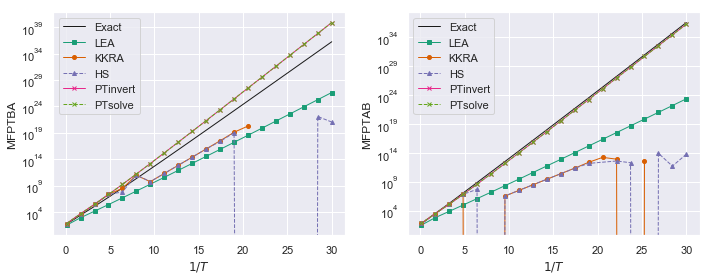

In [49]:
#some mid temperature calculations
invtemps = np.linspace(0.1, 30, 20)
midtemp_df = compare_HS_LEA(1./invtemps, data_path=Path('KTN_data/32state'))
plot_mfpts_16state(midtemp_df)

In [50]:
#some low temperature calculations
invtemps = np.linspace(50, 200, 10)
lowtemp_df = compare_HS_LEA(1./invtemps, data_path=Path('KTN_data/32state'))

/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:586: RuntimeWarning: divide by zero encountered in true_divide
  MFPTBA = tau_Fs[r_AS]/P_BA


Hummer Szabo had the following error: singular matrix


/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: divide by zero encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: invalid value encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:906: RuntimeWarning: invalid value encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:402: RuntimeWarning: invalid value encountered in greater
  nBd[Bd>0.99] = Bnd[Bd>0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:403: RuntimeWarning: invalid value encountered in less
  nBd[Bd<0.99] = 1.0-Bd[Bd<0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:579: RuntimeWarning: divide by zero encountered in true_divide
  tau_Fs 

Hummer Szabo had the following error: singular matrix
Hummer Szabo had the following error: singular matrix


/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: divide by zero encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:906: RuntimeWarning: invalid value encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:402: RuntimeWarning: invalid value encountered in greater
  nBd[Bd>0.99] = Bnd[Bd>0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:403: RuntimeWarning: invalid value encountered in less
  nBd[Bd<0.99] = 1.0-Bd[Bd<0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:579: RuntimeWarning: divide by zero encountered in true_divide
  tau_Fs = 1./rD


Hummer Szabo had the following error: singular matrix


/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/partialGT.py:587: RuntimeWarning: divide by zero encountered in true_divide
  MFPTAB = tau_Fs[r_BS]/P_AB


Hummer Szabo had the following error: singular matrix


/Users/deepti/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: LinAlgWarning: Ill-conditioned matrix (rcond=2.03302e-18): result may not be accurate.
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: invalid value encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:402: RuntimeWarning: invalid value encountered in greater
  nBd[Bd>0.99] = Bnd[Bd>0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:403: RuntimeWarning: invalid value encountered in less
  nBd[Bd<0.99] = 1.0-Bd[Bd<0.99]


Hummer Szabo had the following error: singular matrix


/Users/deepti/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: LinAlgWarning: Ill-conditioned matrix (rcond=9.50228e-21): result may not be accurate.


Hummer Szabo had the following error: singular matrix


/Users/deepti/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: LinAlgWarning: Ill-conditioned matrix (rcond=9.54012e-23): result may not be accurate.
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: divide by zero encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: invalid value encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:906: RuntimeWarning: invalid value encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:402: RuntimeWarning: invalid value encountered in greater
  nBd[Bd>0.99] = Bnd[Bd>0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:403: RuntimeWarning: invalid value encountered in less
  nBd[Bd<

Hummer Szabo had the following error: singular matrix


/Users/deepti/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: LinAlgWarning: Ill-conditioned matrix (rcond=9.7433e-25): result may not be accurate.
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: invalid value encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:402: RuntimeWarning: invalid value encountered in greater
  nBd[Bd>0.99] = Bnd[Bd>0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:403: RuntimeWarning: invalid value encountered in less
  nBd[Bd<0.99] = 1.0-Bd[Bd<0.99]


Hummer Szabo had the following error: singular matrix


/Users/deepti/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: LinAlgWarning: Ill-conditioned matrix (rcond=3.7089e-27): result may not be accurate.
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:193: RuntimeWarning: invalid value encountered in true_divide
  Bxj = np.ravel(Bxj.flatten() / b_xx)
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:402: RuntimeWarning: invalid value encountered in greater
  nBd[Bd>0.99] = Bnd[Bd>0.99]
/Users/deepti/Documents/Wales/git-remotes/KTN_python/lib/gt_tools.py:403: RuntimeWarning: invalid value encountered in less
  nBd[Bd<0.99] = 1.0-Bd[Bd<0.99]


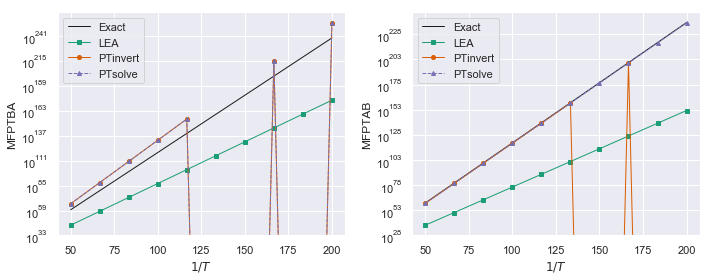

In [51]:
plot_mfpts_16state(lowtemp_df, excludeHS=True)

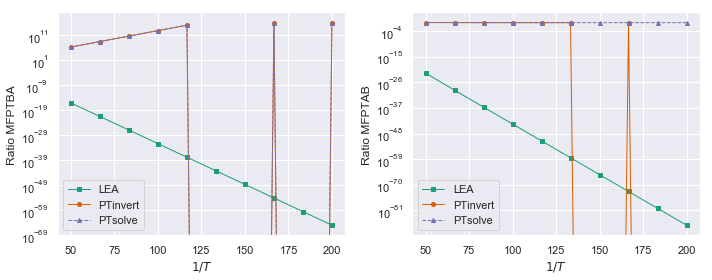

In [52]:
plot_ratios_16state(lowtemp_df, excludeHS=True)

In [38]:
#check condition number of weighted-MFPT matrix
#condition number of weighted-MFPT matrix vs. 1/T
data_path = Path('KTN_data/32state')
invtemps = np.linspace(50, 200, 10)
#temp = 1./76
cond_numbers = []
for temp in 1./invtemps:
    mfpt, pi = pgt.get_intermicrostate_mfpts_GT(temp, data_path)
    print(mfpt.shape)
    #compute weighted-MFPT between communities
    commpi = ktn.get_comm_stat_probs(np.log(pi), log=False)
    pt = ktn.get_kells_cluster_passage_times(pi, commpi, mfpt)
    cond_numbers.append(np.linalg.cond(pt))

(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)


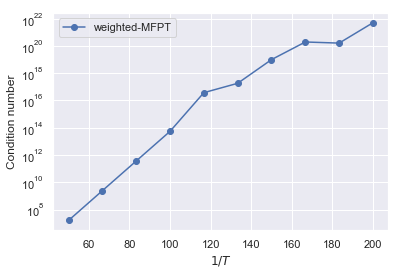

In [39]:
fig, ax = plt.subplots()
ax.plot(invtemps, cond_numbers, 'o-', label='weighted-MFPT')
ax.set_xlabel(r"$1/T$")
ax.set_ylabel("Condition number")
ax.set_yscale('log')
plt.legend()